In [7]:
import pandas as pd
import numpy as np

def get_csv(loc):
    df = pd.read_csv(loc)
    df.set_index("_0", inplace=True)
    df.sort_index(inplace=True)
    df.dropna(inplace=True)
    return df

dataset = get_csv("csv/data_lof.csv")
dataset.drop(['label'], axis=1, inplace=True)
df = dataset.copy()
dataset = dataset.apply(pd.to_numeric, downcast='float')

In [8]:
from keras.models import Sequential
import tensorflow as tf

In [9]:
from sklearn.preprocessing import RobustScaler
dataset = dataset.values
scaler = RobustScaler()
dataset = scaler.fit_transform(dataset)

In [10]:
from numpy import array
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 20
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

(53842, 20, 34) (53842, 34)


In [11]:
# define model
n_features = dataset.shape[1]

# define model
model = Sequential()
model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(n_steps, n_features)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
        tf.keras.layers.Dense(n_features)])


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True) 
]

model.compile(loss="mse", optimizer="adam")

In [12]:
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.25, callbacks=callbacks)

Epoch 1/10
1262/1262 [==============================] - ETA: 0s - loss: 32.3497
Epoch 1: val_loss improved from inf to 0.21860, saving model to weights.h5
1262/1262 [==============================] - 32s 23ms/step - loss: 32.3497 - val_loss: 0.2186 - lr: 0.0010
Epoch 2/10
1261/1262 [============================>.] - ETA: 0s - loss: 13.6712
Epoch 2: val_loss did not improve from 0.21860
1262/1262 [==============================] - 27s 21ms/step - loss: 13.6615 - val_loss: 0.2601 - lr: 0.0010
Epoch 3/10
1262/1262 [==============================] - ETA: 0s - loss: 4.5412
Epoch 3: val_loss did not improve from 0.21860
1262/1262 [==============================] - 27s 21ms/step - loss: 4.5412 - val_loss: 0.2272 - lr: 0.0010
Epoch 4/10
1261/1262 [============================>.] - ETA: 0s - loss: 1.0576
Epoch 4: val_loss did not improve from 0.21860
1262/1262 [==============================] - 28s 22ms/step - loss: 1.0568 - val_loss: 0.2721 - lr: 0.0010
Epoch 5/10
1260/1262 [==================

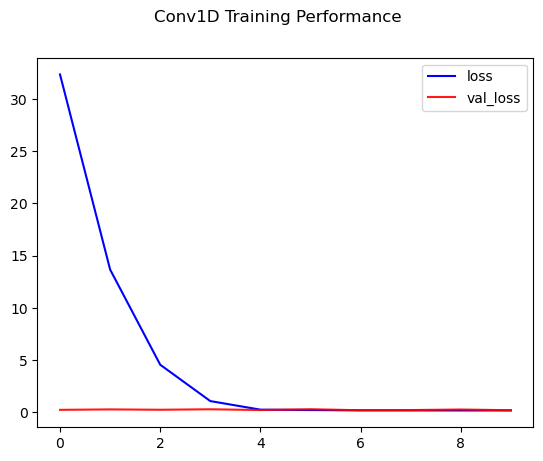

In [13]:
import matplotlib.pyplot as plt

# Investigate training performance:
plt.suptitle('Conv1D Training Performance')
plt.plot(range(0, len(history.epoch)), history.history['loss'], color='blue')
plt.plot(range(0, len(history.epoch)), history.history['val_loss'], color='red', alpha=0.9)
plt.legend(["loss", "val_loss"])
plt.show()

In [14]:
datelist_train = list(df[:-n_steps].index)
datelist_train = [date for date in datelist_train]
datelist_future = pd.date_range(datelist_train[-1], periods=n_steps, freq='1min').tolist()
datelist_future_ = []

for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp)

predictions_future = model.predict(X[-n_steps:])
predictions_train = model.predict(X)
y_pred_future = scaler.inverse_transform(predictions_future)
y_pred_train = scaler.inverse_transform(predictions_train)

#dtype and value transform
y_pred_future = pd.DataFrame(y_pred_future, columns=df.columns).astype(df.dtypes)
for column in y_pred_future.columns:
    if y_pred_future[column].dtype == np.float64:
        y_pred_future[column] = np.round(y_pred_future[column], 2)
    y_pred_future.loc[y_pred_future[column] < 0, column] = 0

y_pred_train = pd.DataFrame(y_pred_train, columns=df.columns).astype(df.dtypes)
for column in y_pred_train.columns:
    if y_pred_train[column].dtype == np.float64:
        y_pred_train[column] = np.round(y_pred_train[column], 2)
    y_pred_train.loc[y_pred_train[column] < 0, column] = 0

y_pred_future = pd.DataFrame(y_pred_future, columns=df.columns)
y_pred_train = pd.DataFrame(y_pred_train, columns=df.columns)
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=df.columns).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=df.columns).set_index(pd.Series(datelist_train))

PREDICTIONS_FUTURE.dropna(inplace=True, axis=1)

1683/1683 [==============================] - 11s 6ms/step


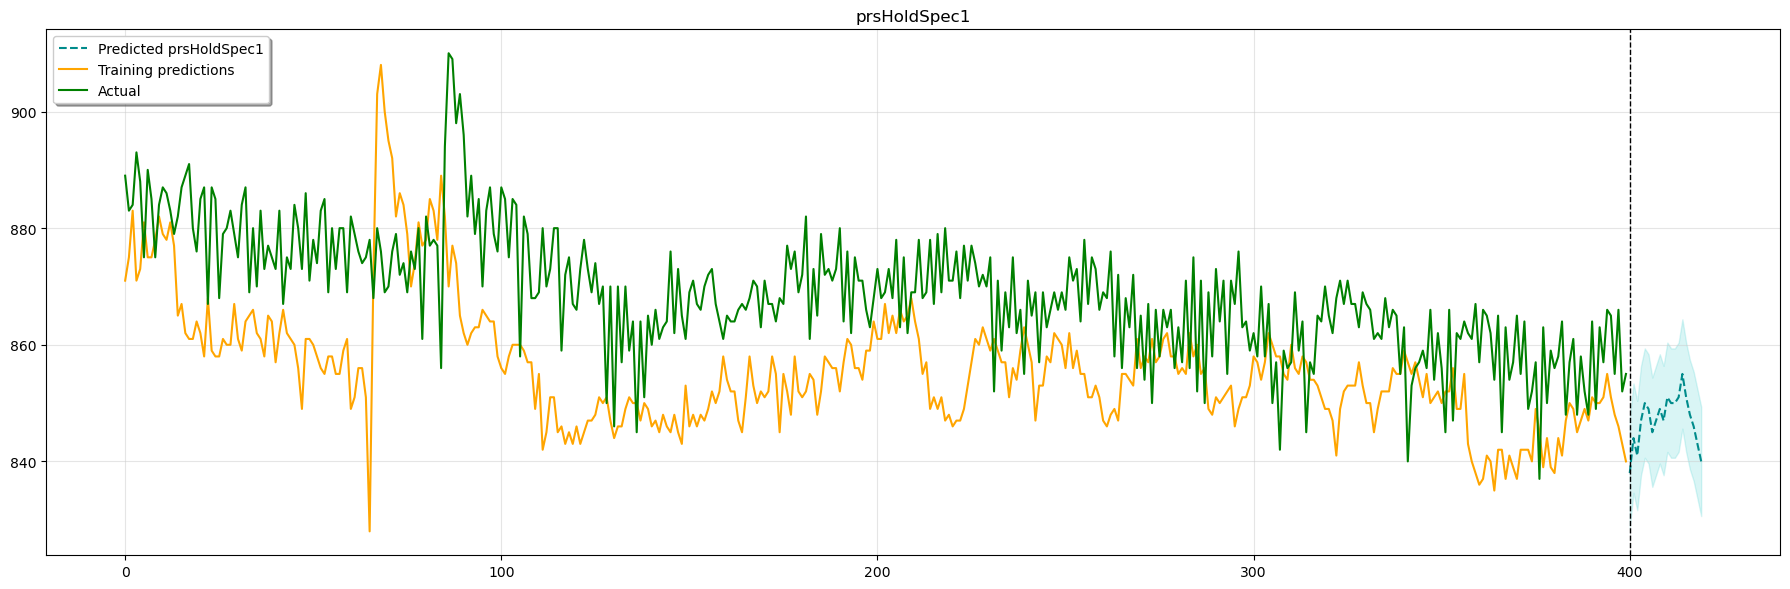

In [15]:
import matplotlib.pyplot as plt

amount = 400
column = "prsHoldSpec1"
thres = abs(df[column][:-n_steps] - PREDICTION_TRAIN[column]).mean()
lower = PREDICTIONS_FUTURE[column] - thres
upper = PREDICTIONS_FUTURE[column] + thres
# Set plot size
# from pylab import rcParams
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.autolayout"] = True

x1 = np.arange(start=amount, stop=amount + n_steps)
x2 = np.arange(len(PREDICTION_TRAIN[:amount]))
x3 = np.arange(len(dataset[:amount]))

plt.plot(x1, PREDICTIONS_FUTURE[column], color="darkcyan", linestyle="--", label=f'Predicted {column}')
plt.fill_between(x1, lower, upper, color='c', alpha=.15)

plt.plot(x2, PREDICTION_TRAIN[column].tail(amount), color='orange', label='Training predictions')
plt.plot(x3, df[column][:-n_steps].tail(amount), color='green', label='Actual')

plt.axvline(x = amount, color='black', linewidth=1, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title(column)
plt.show()

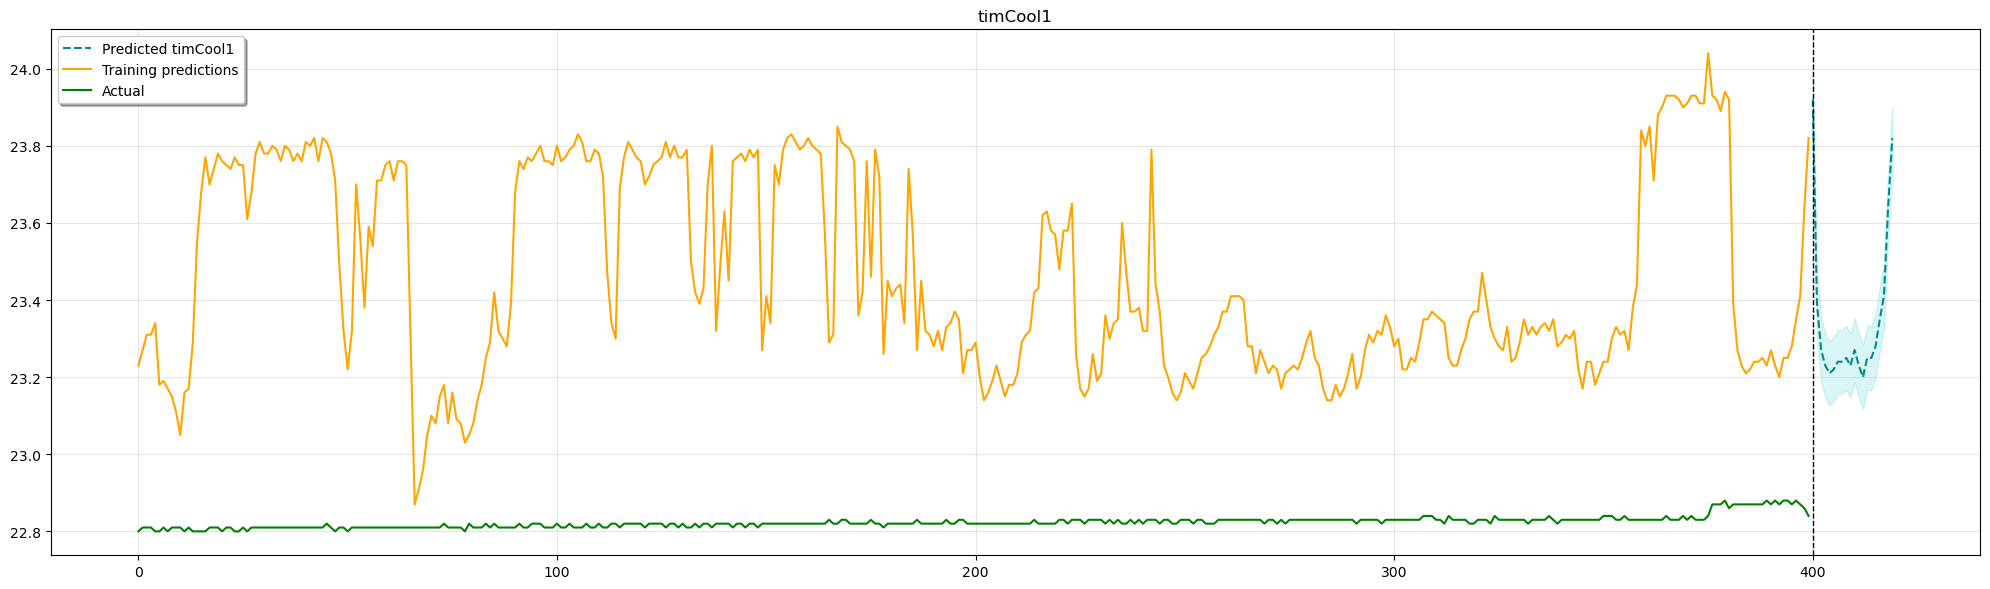

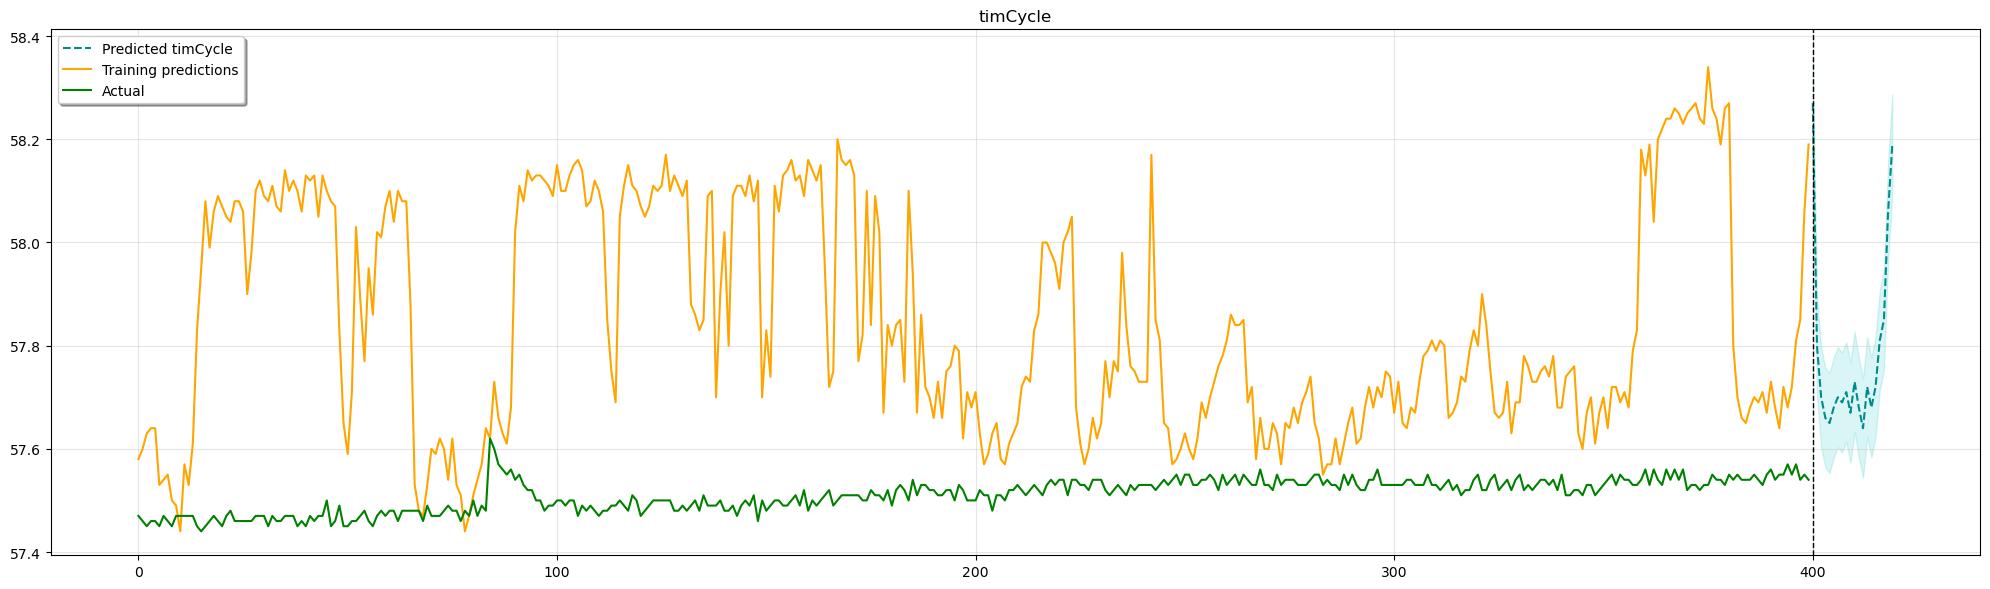

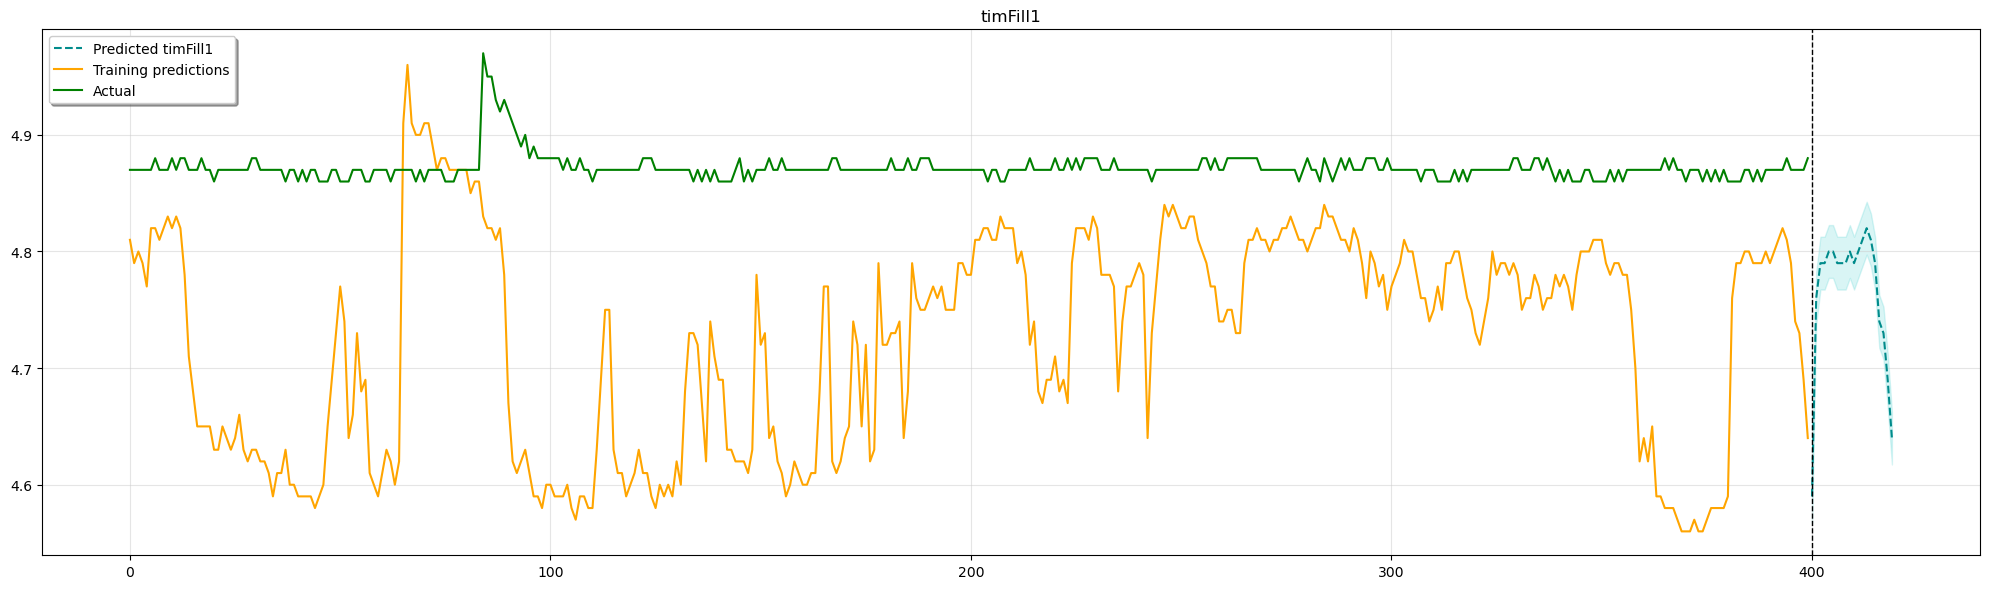

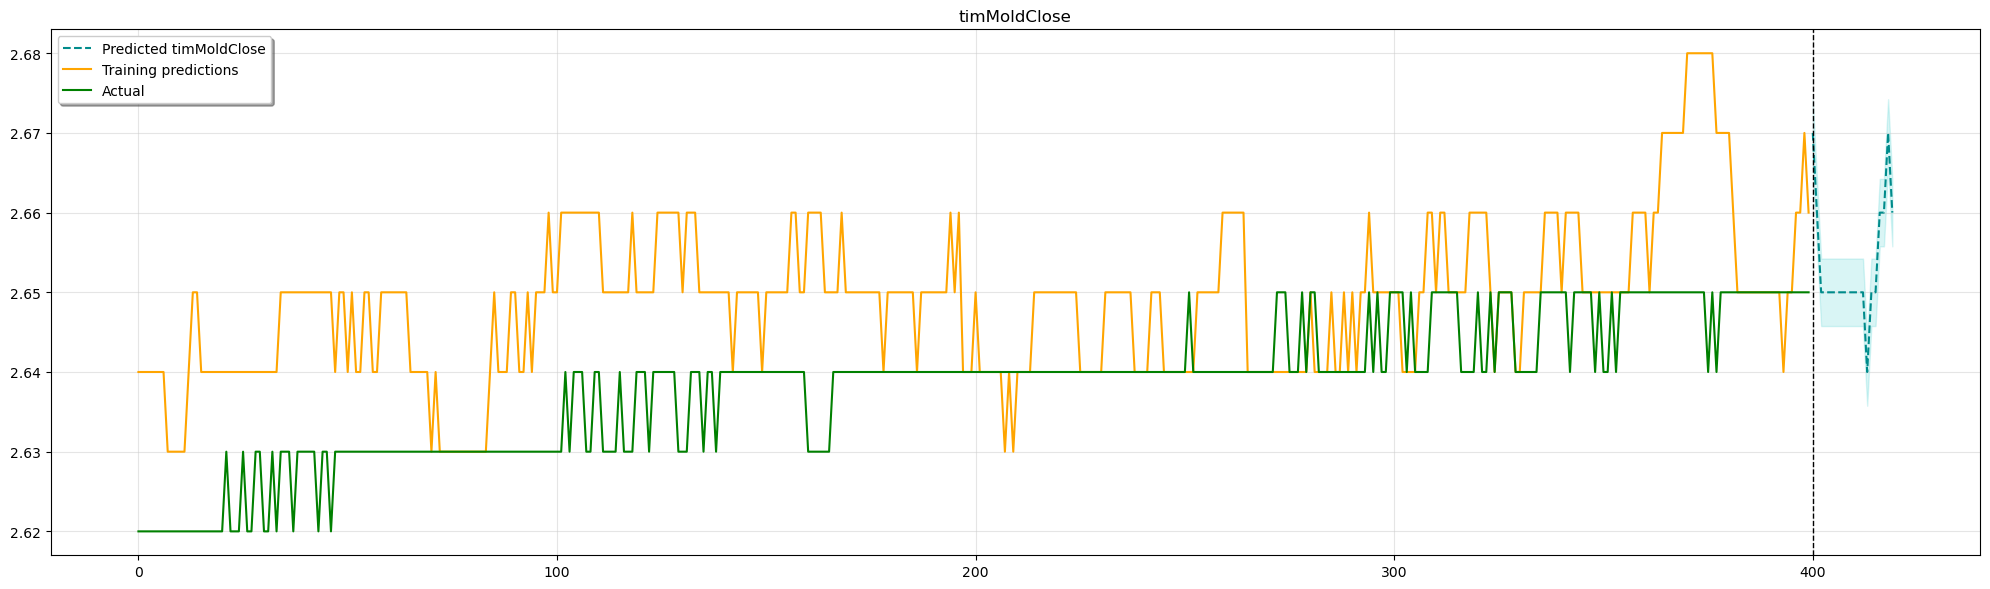

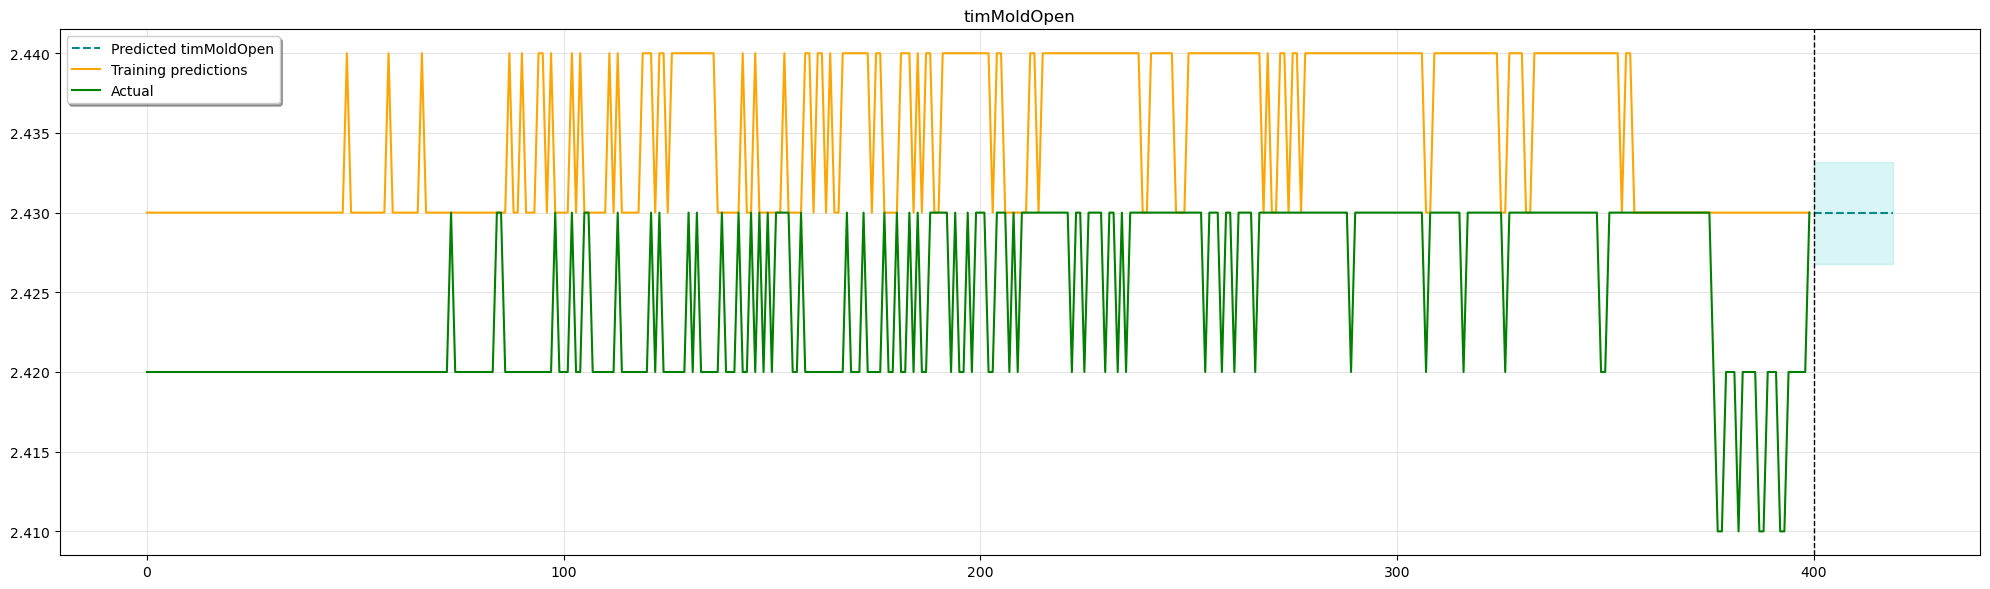

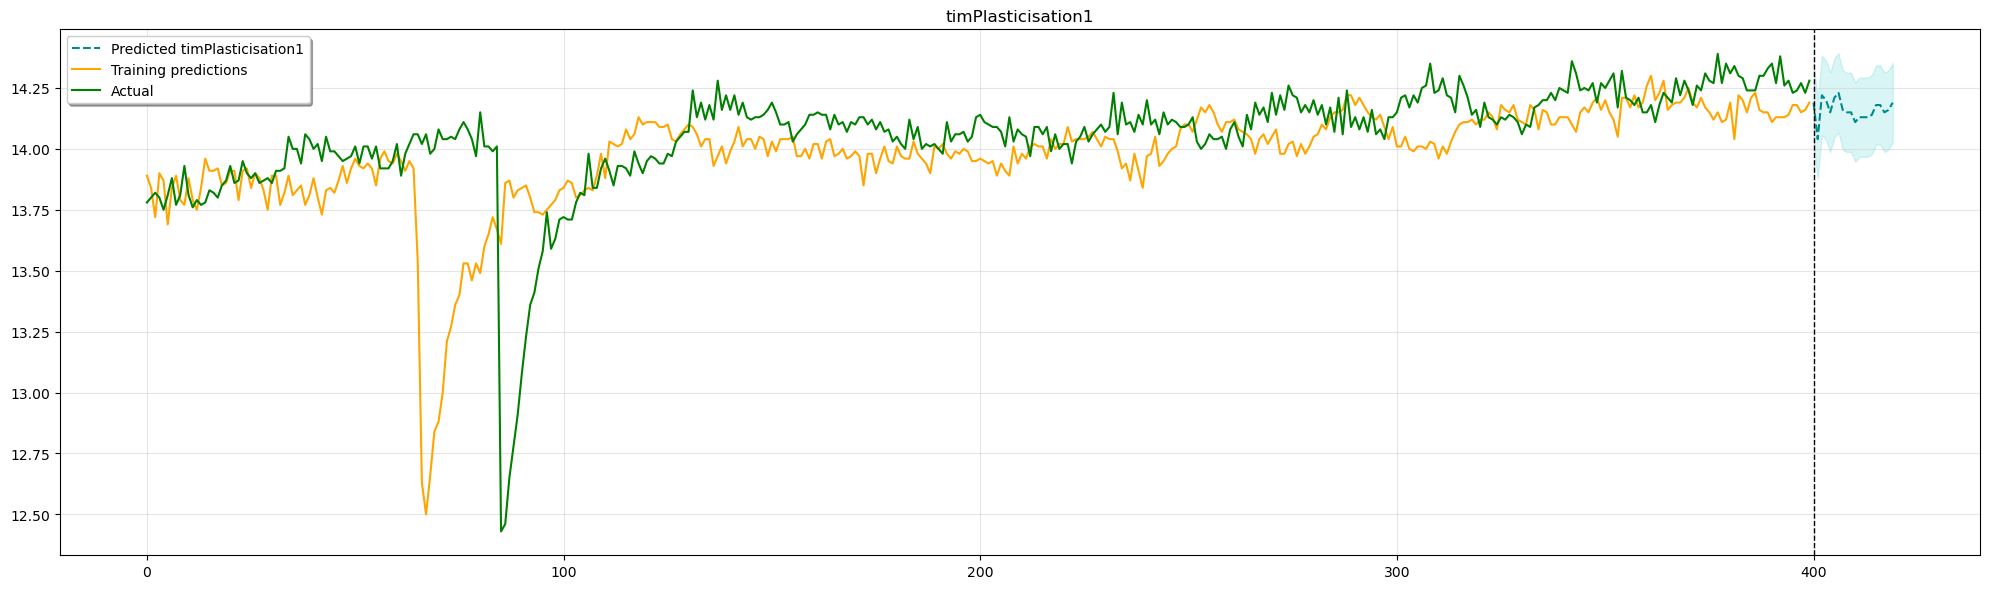

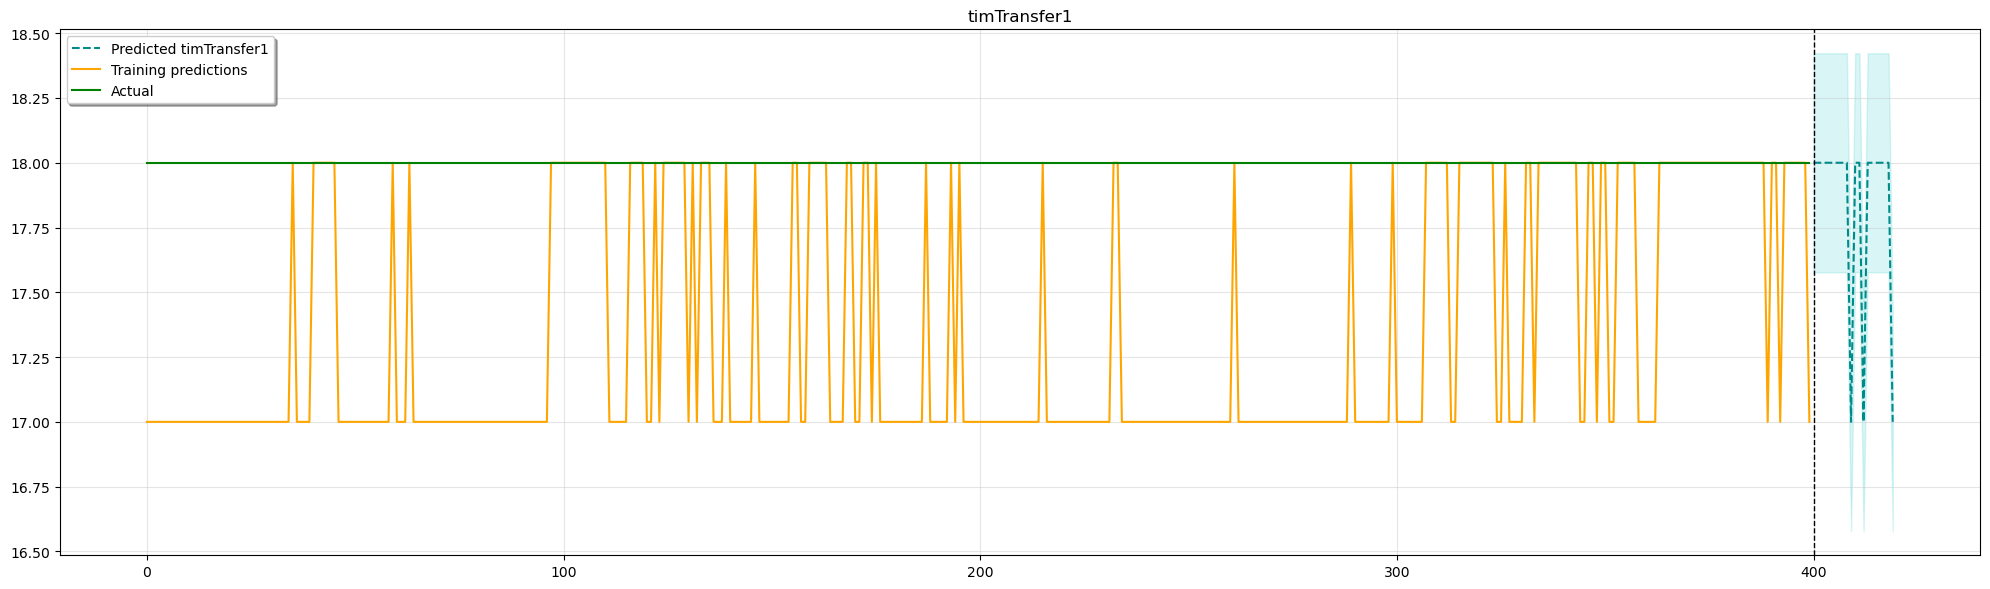

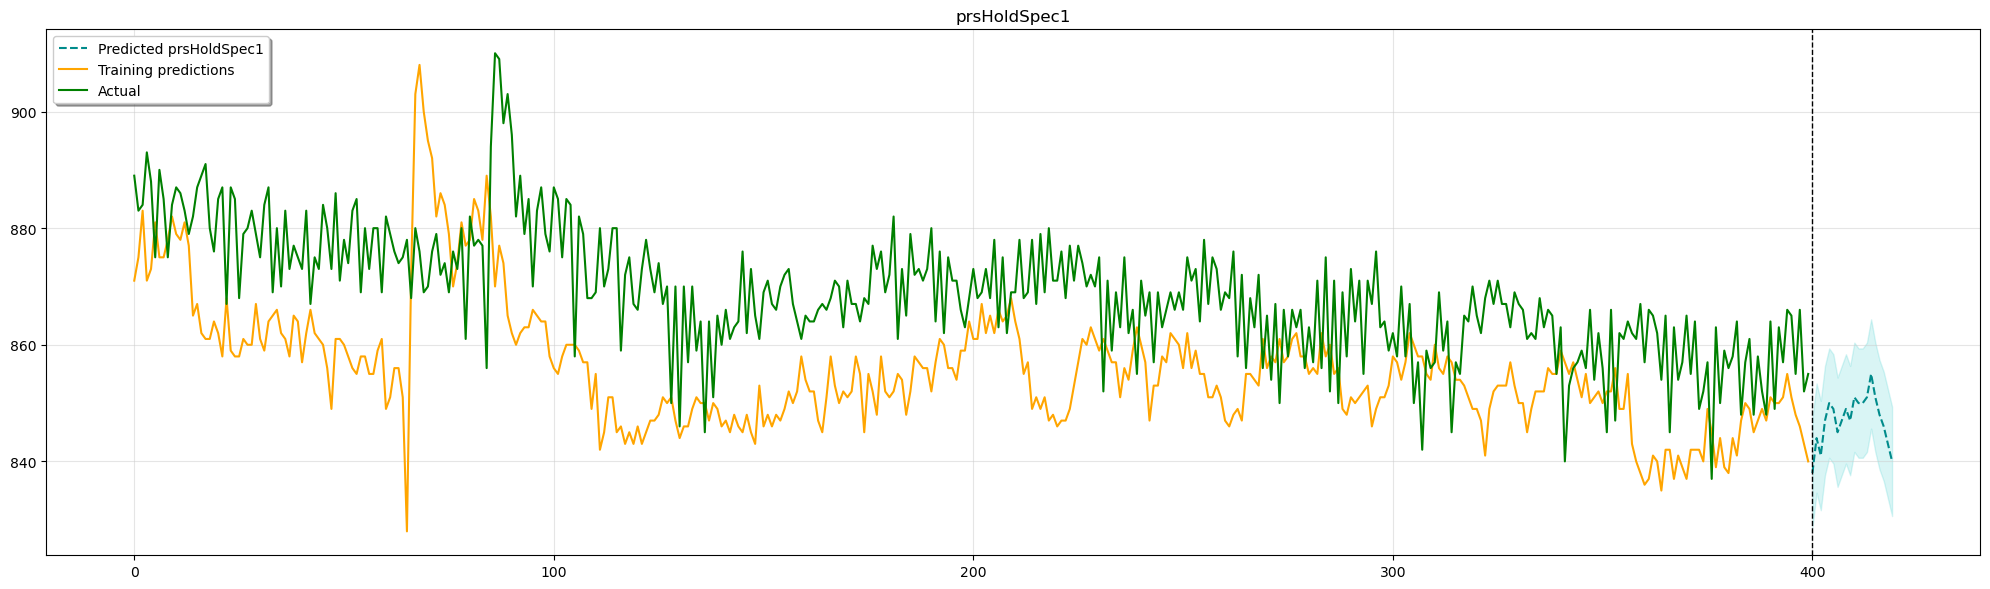

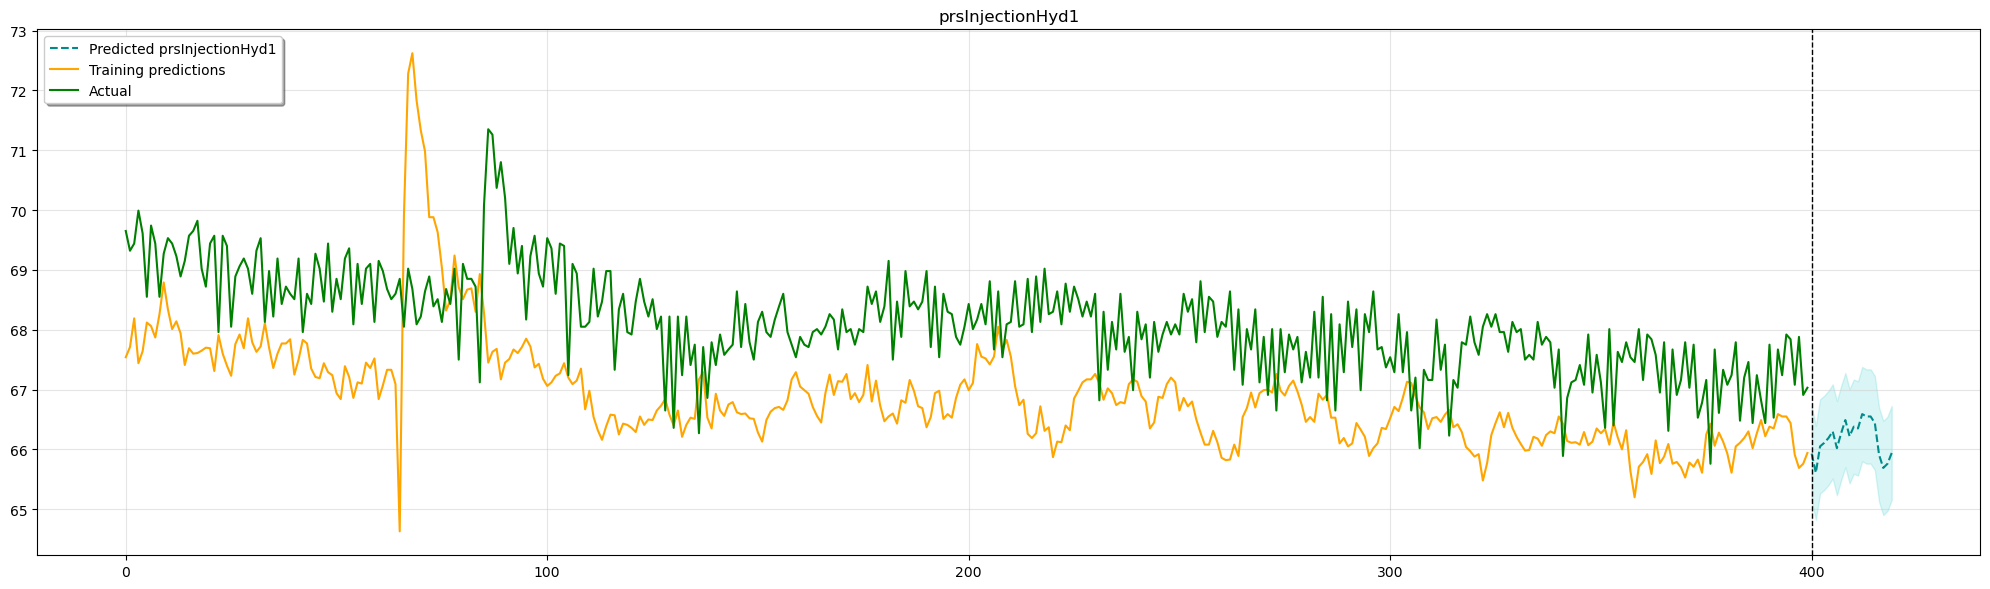

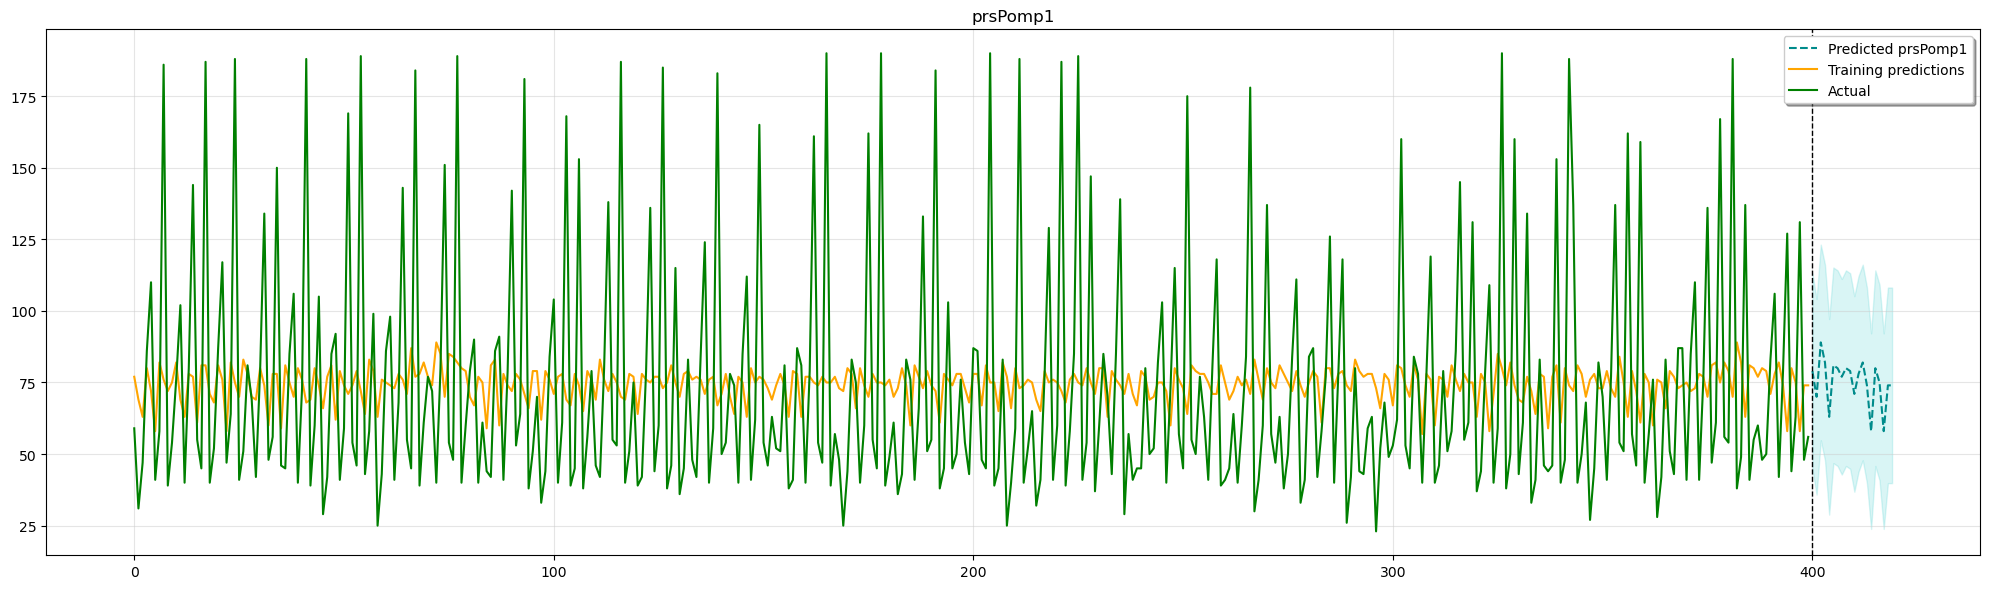

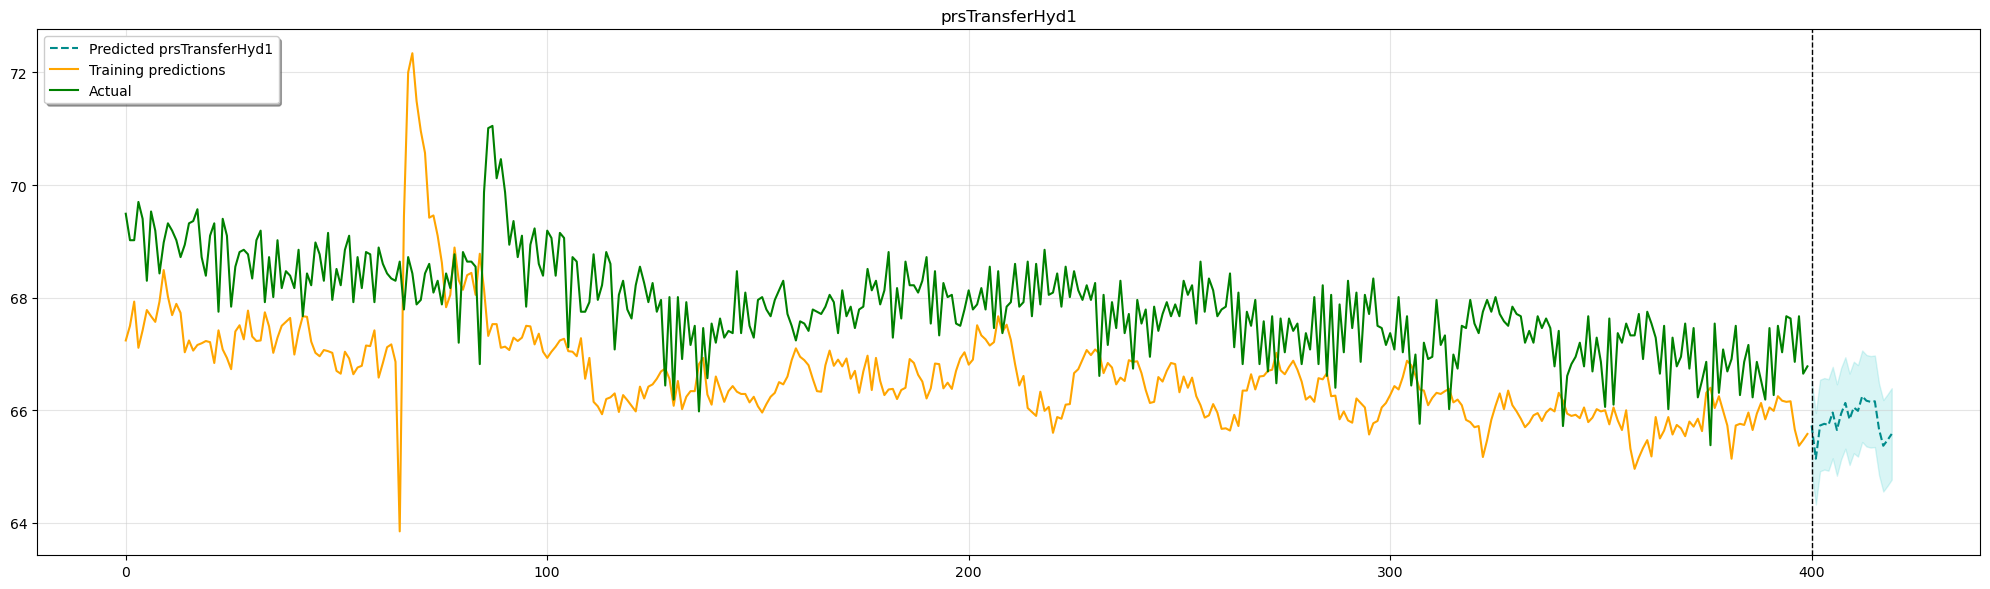

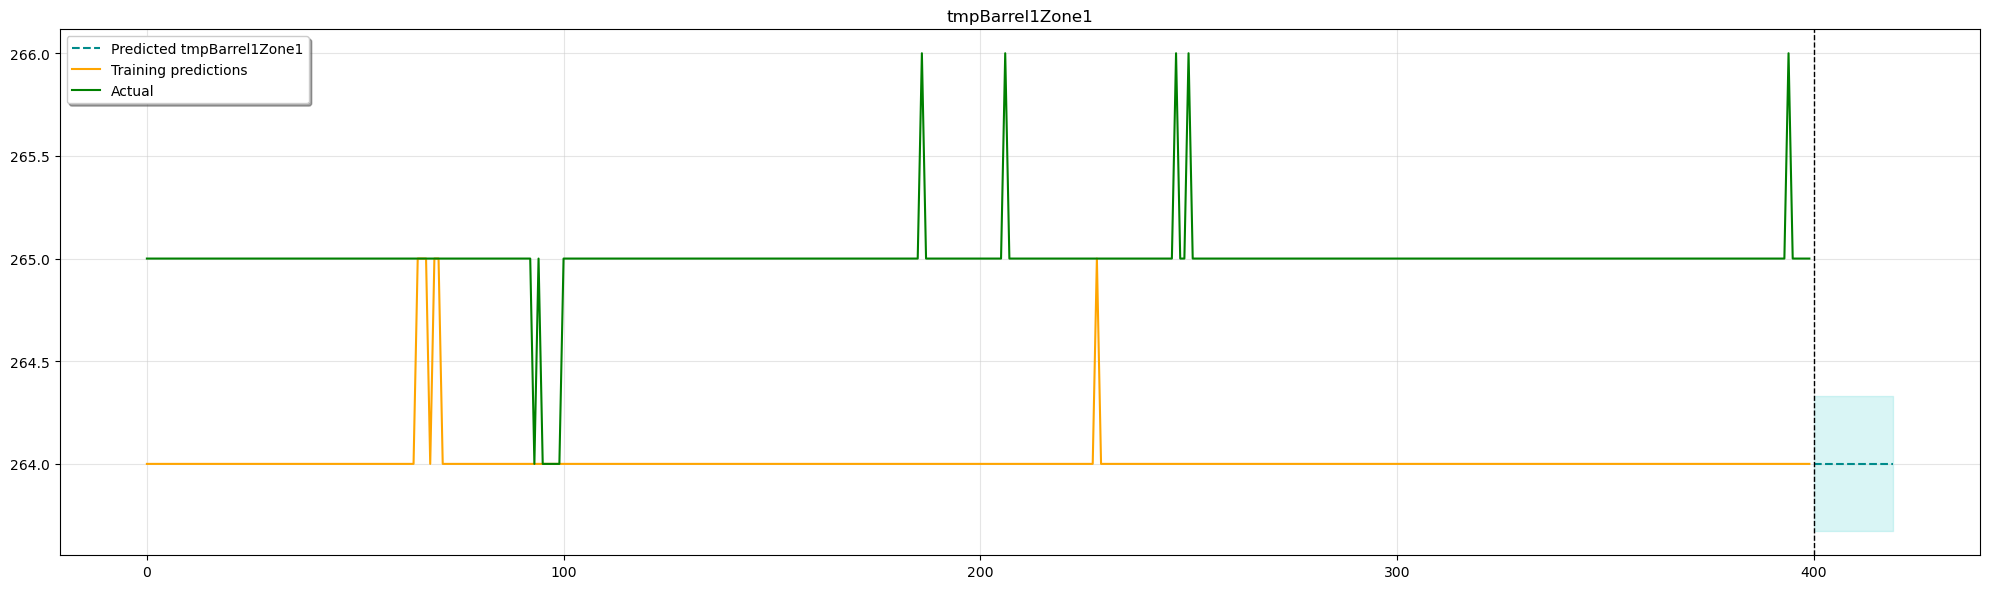

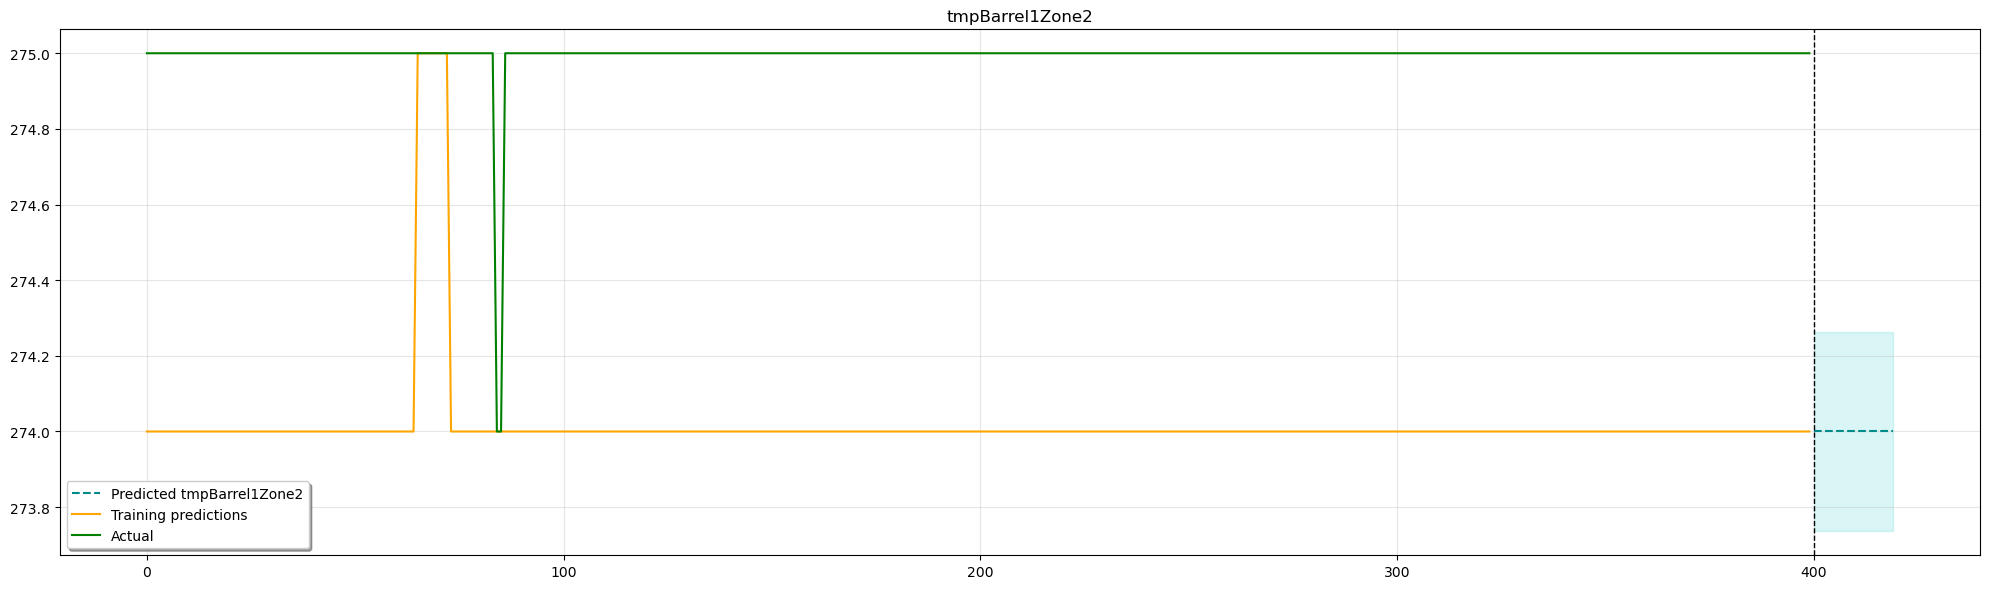

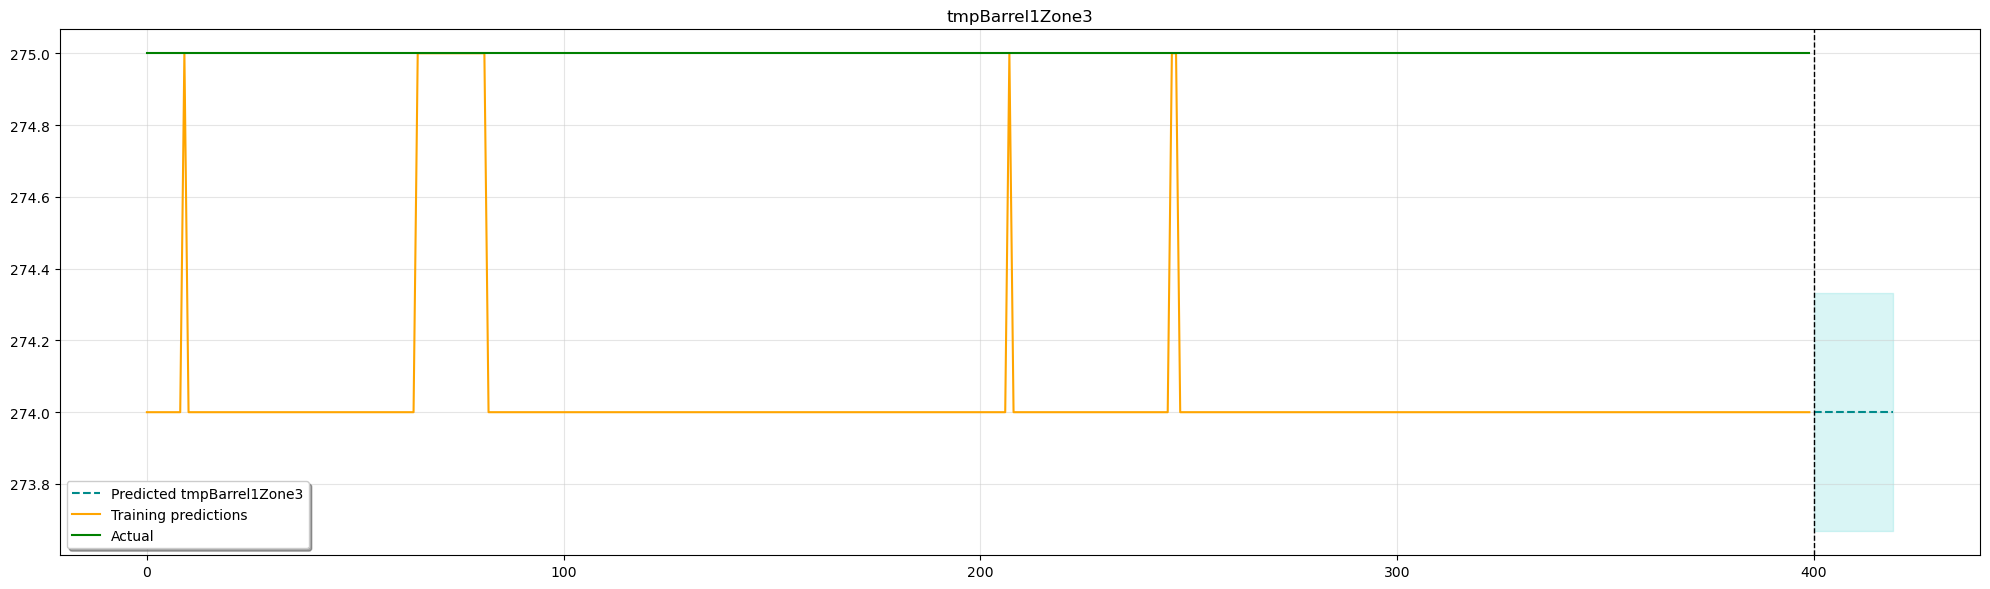

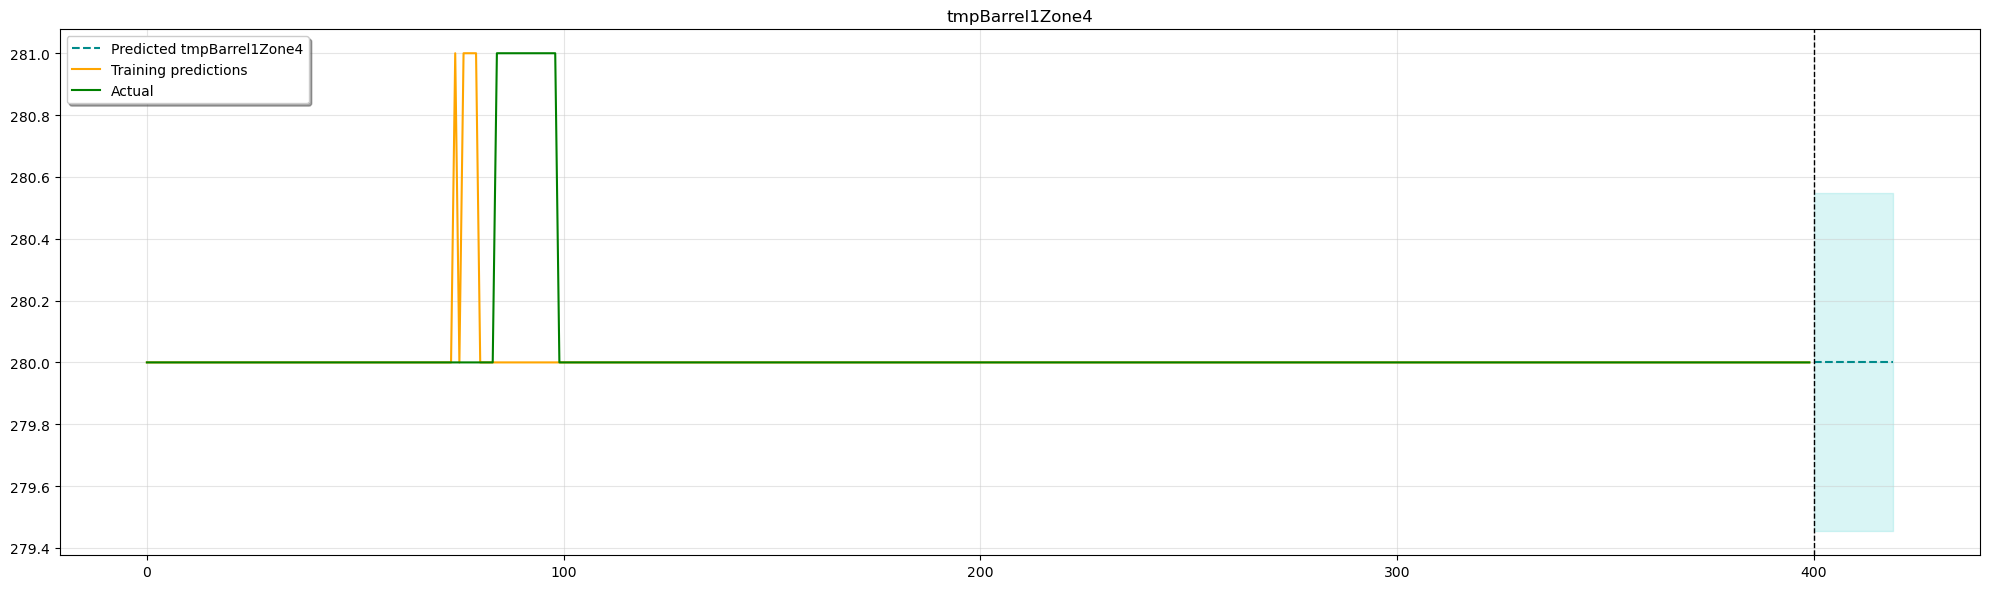

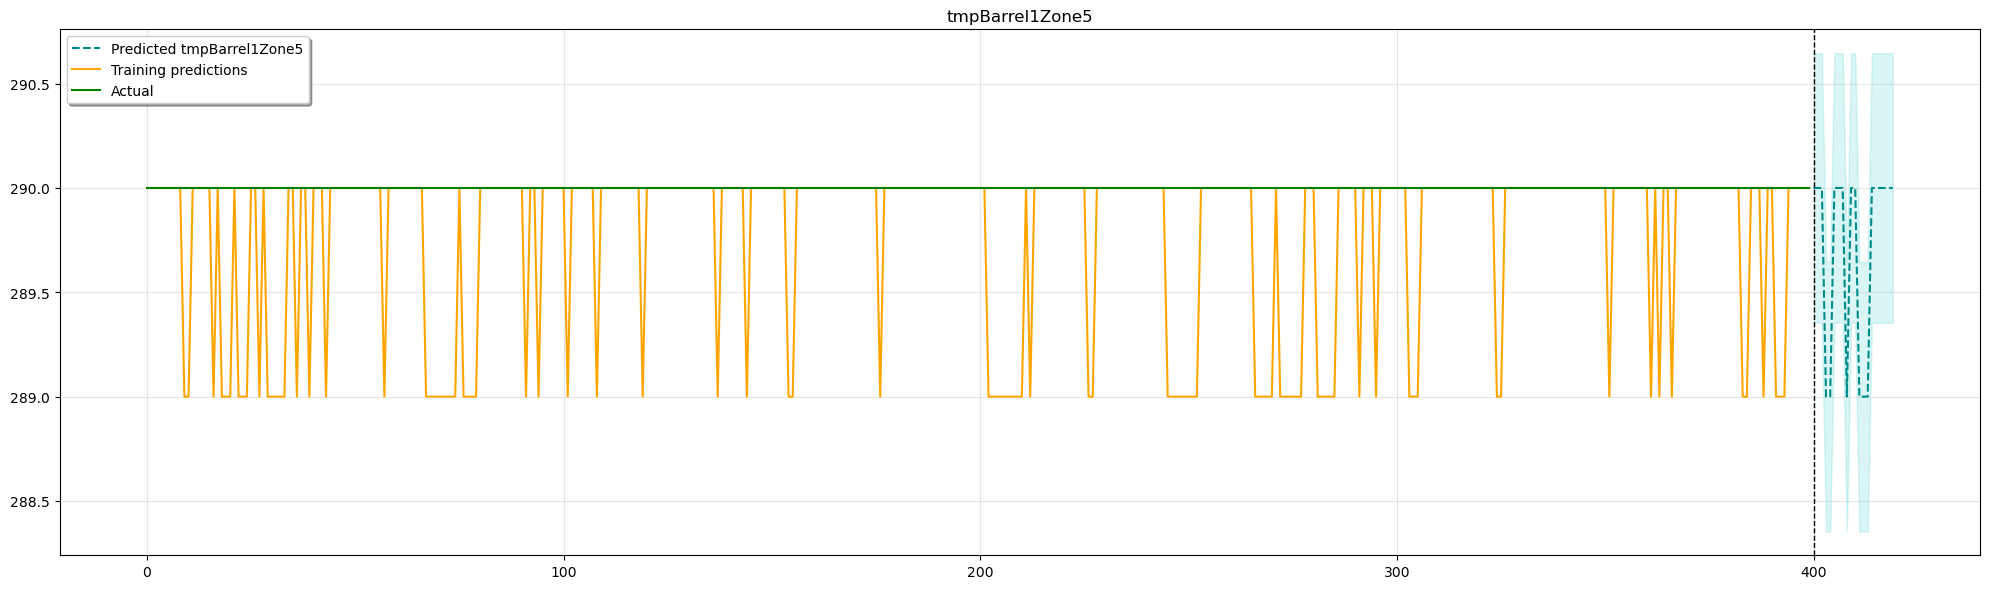

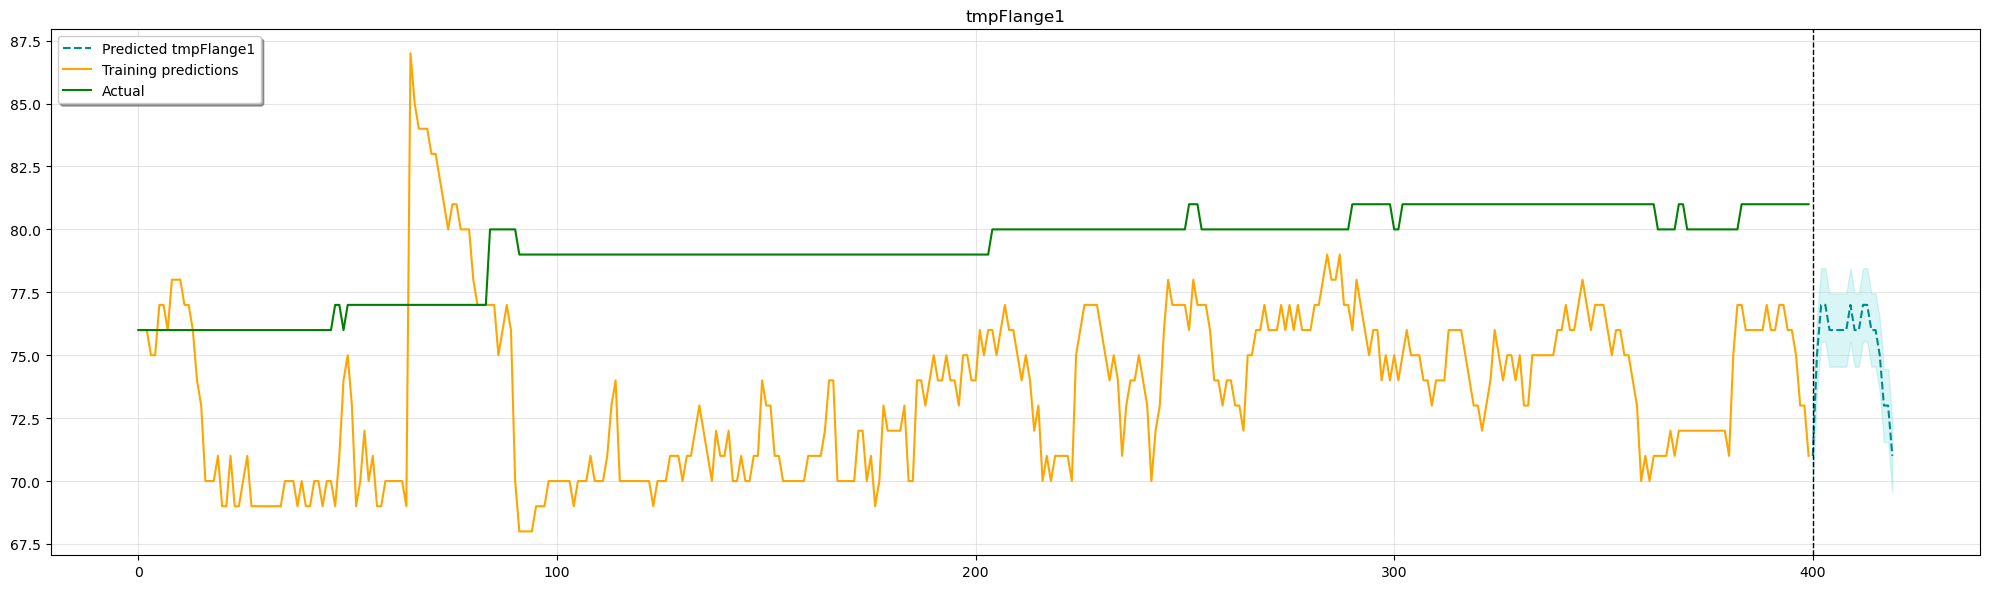

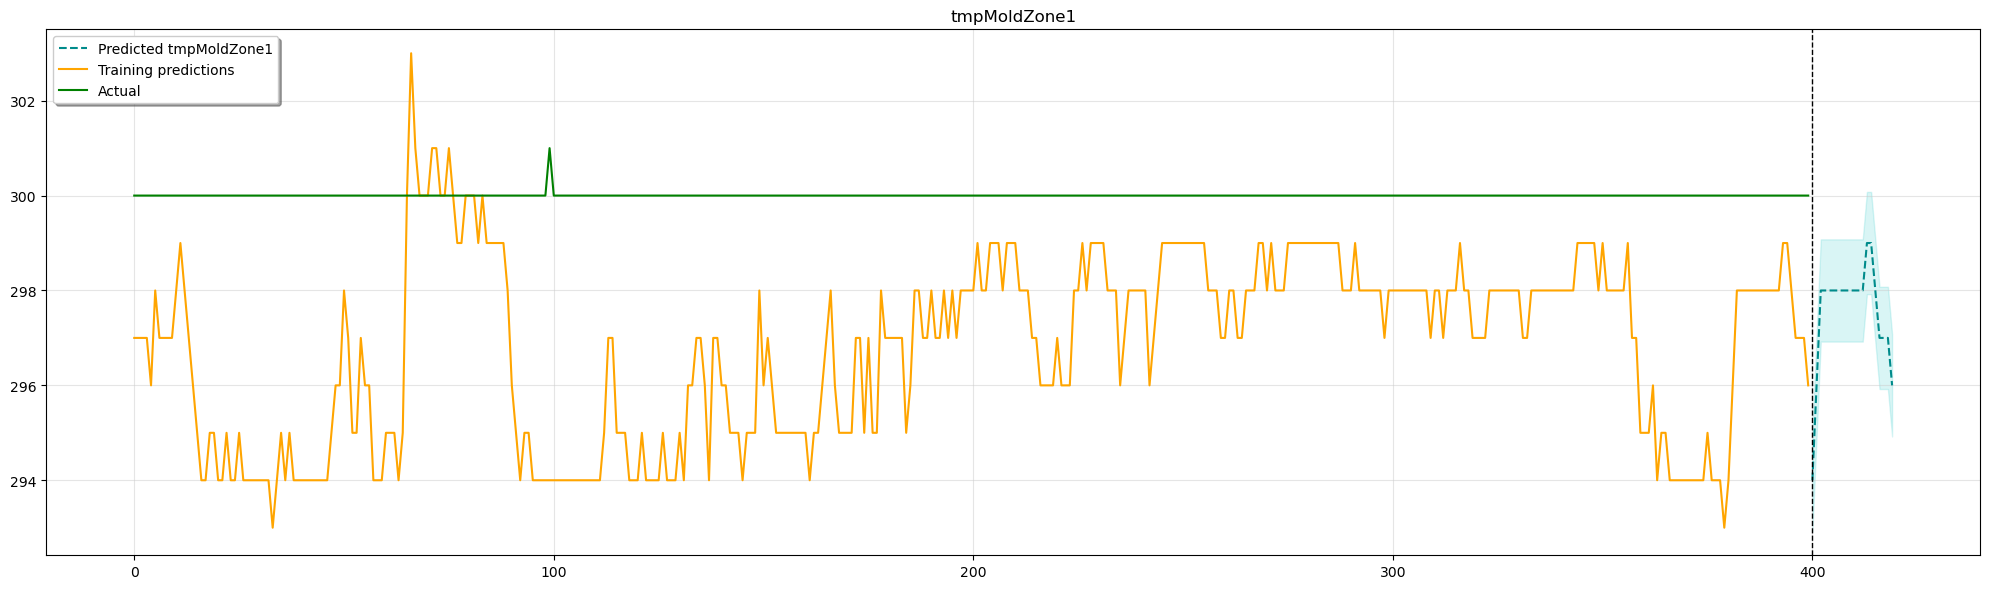

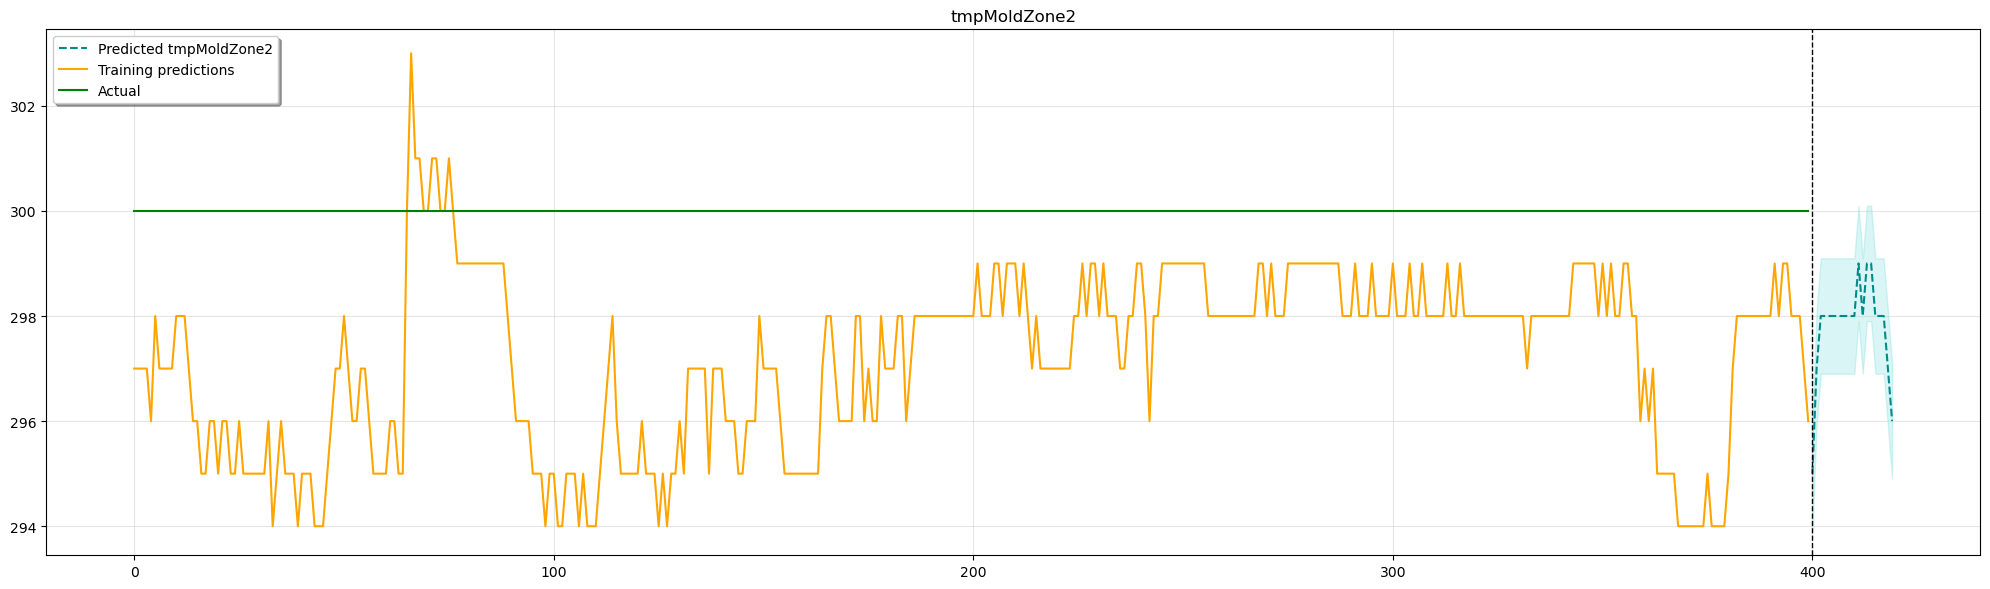

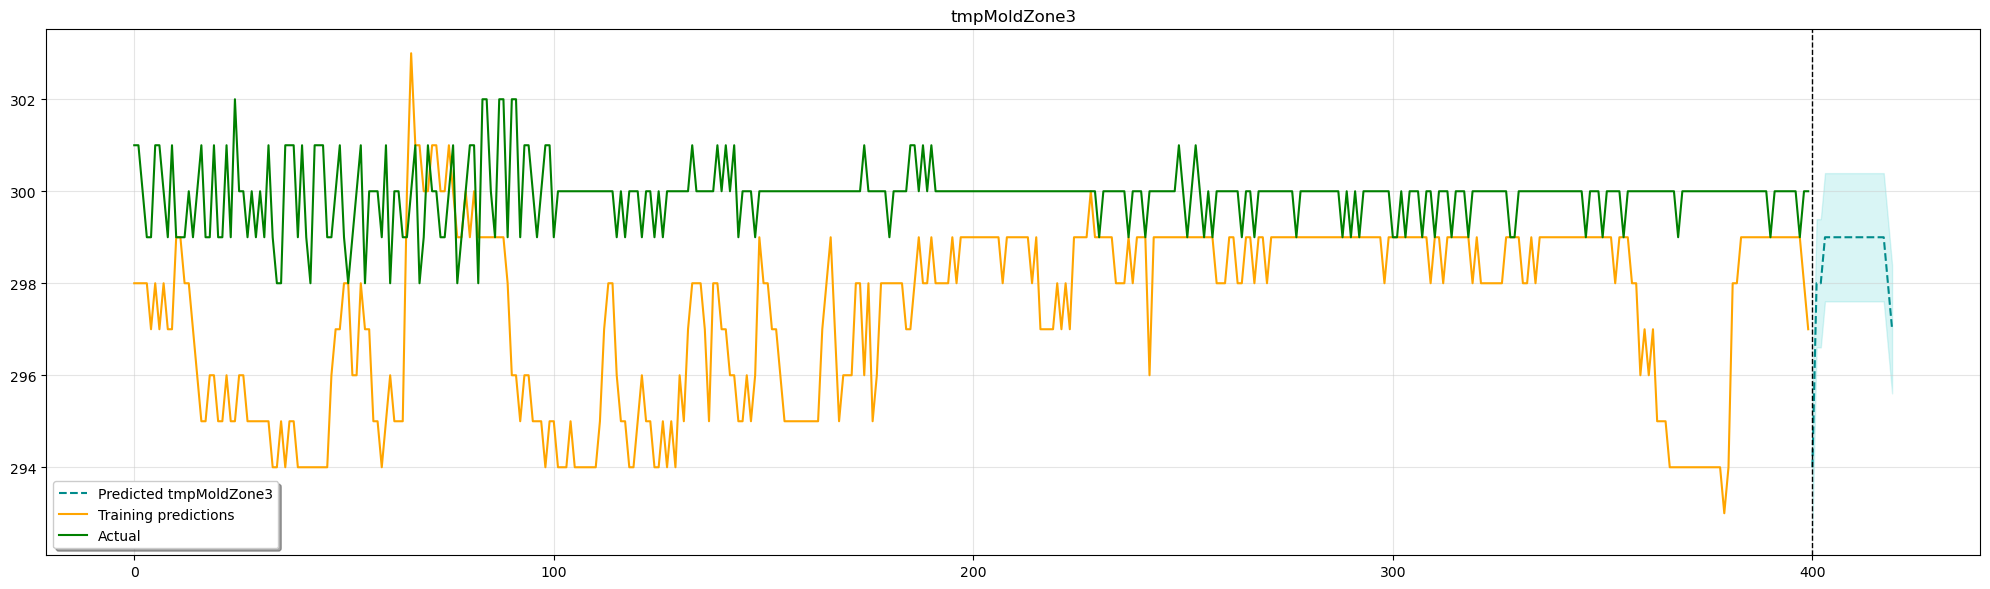

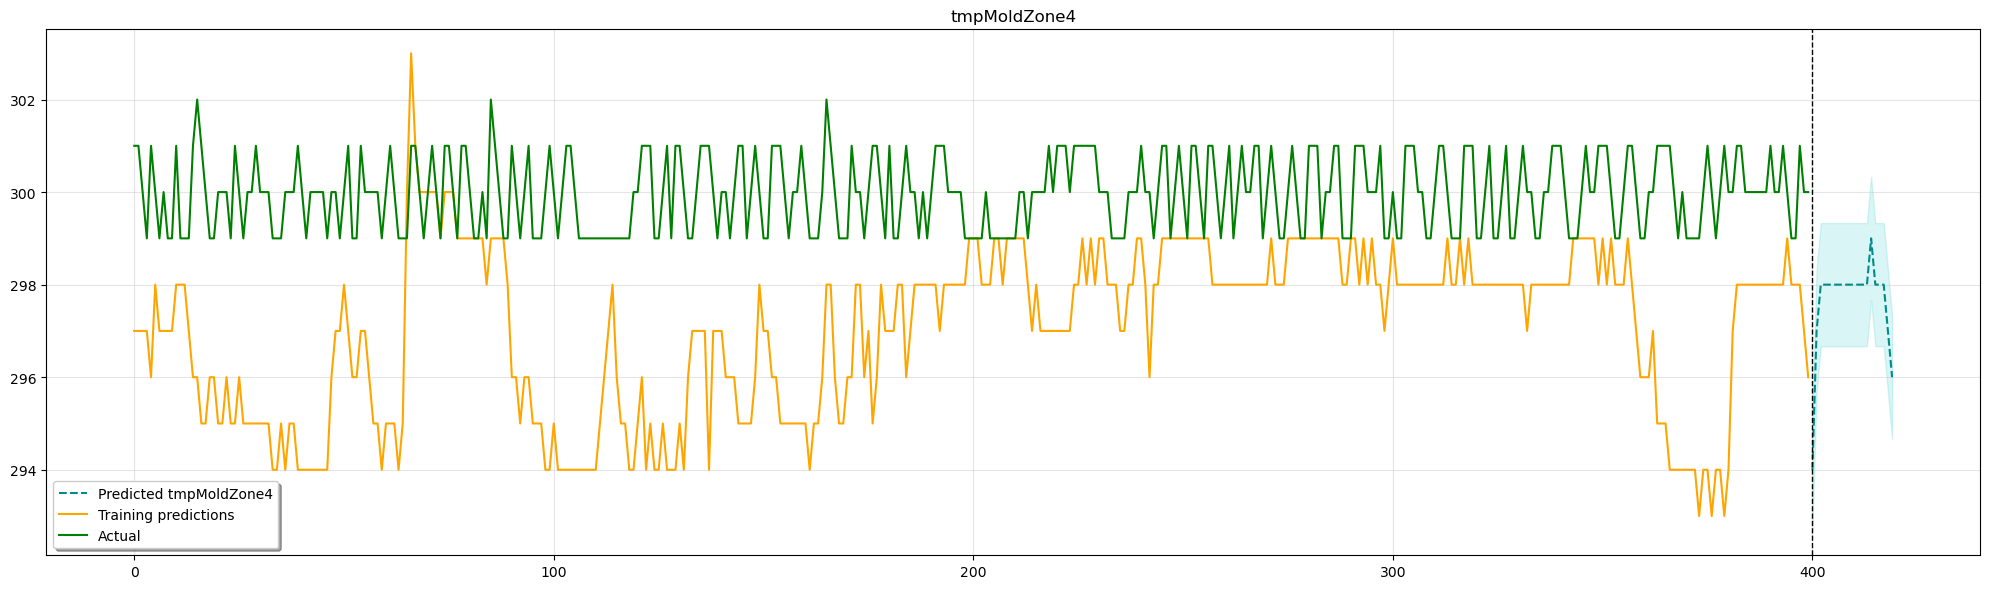

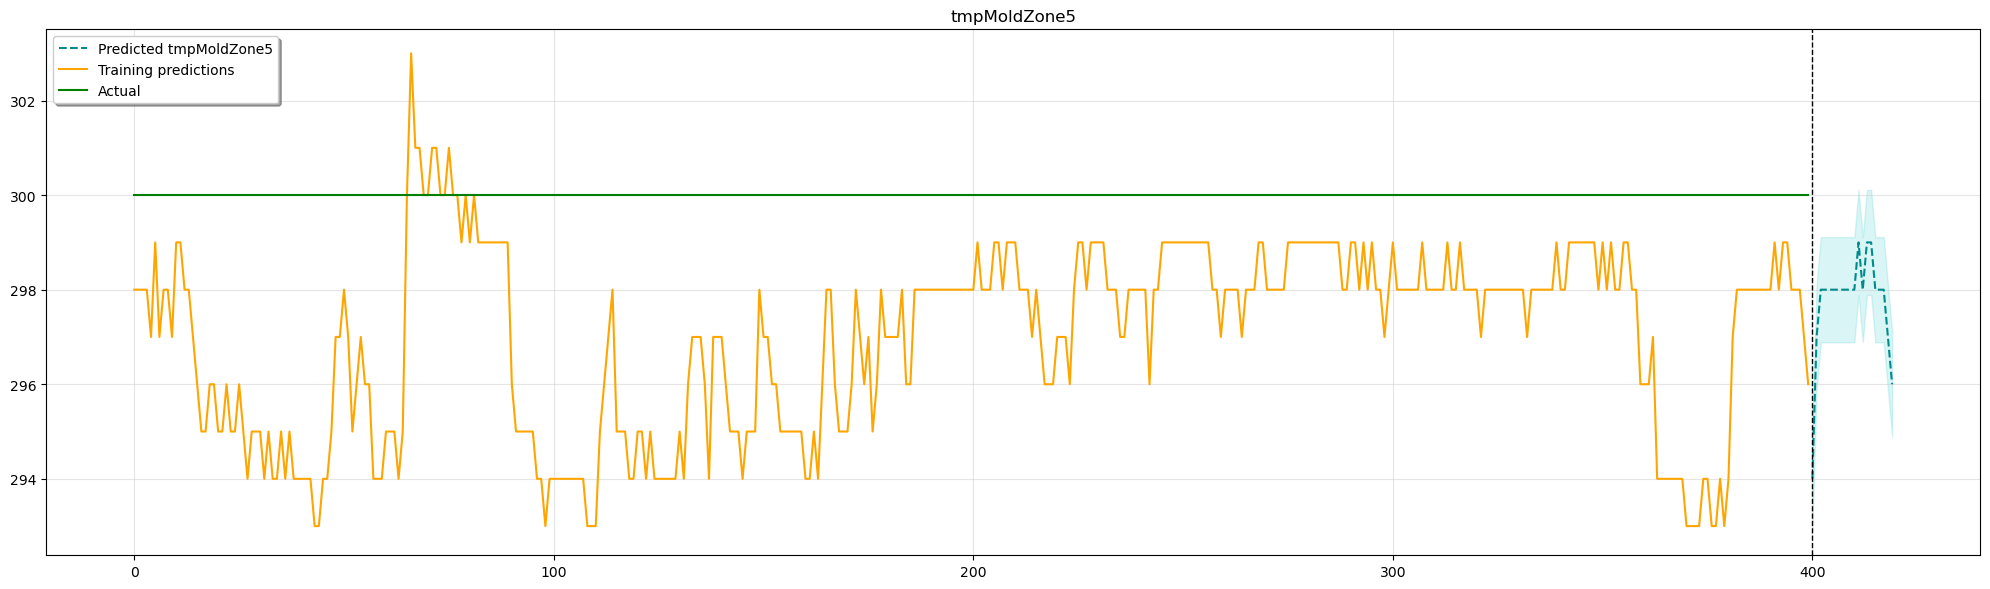

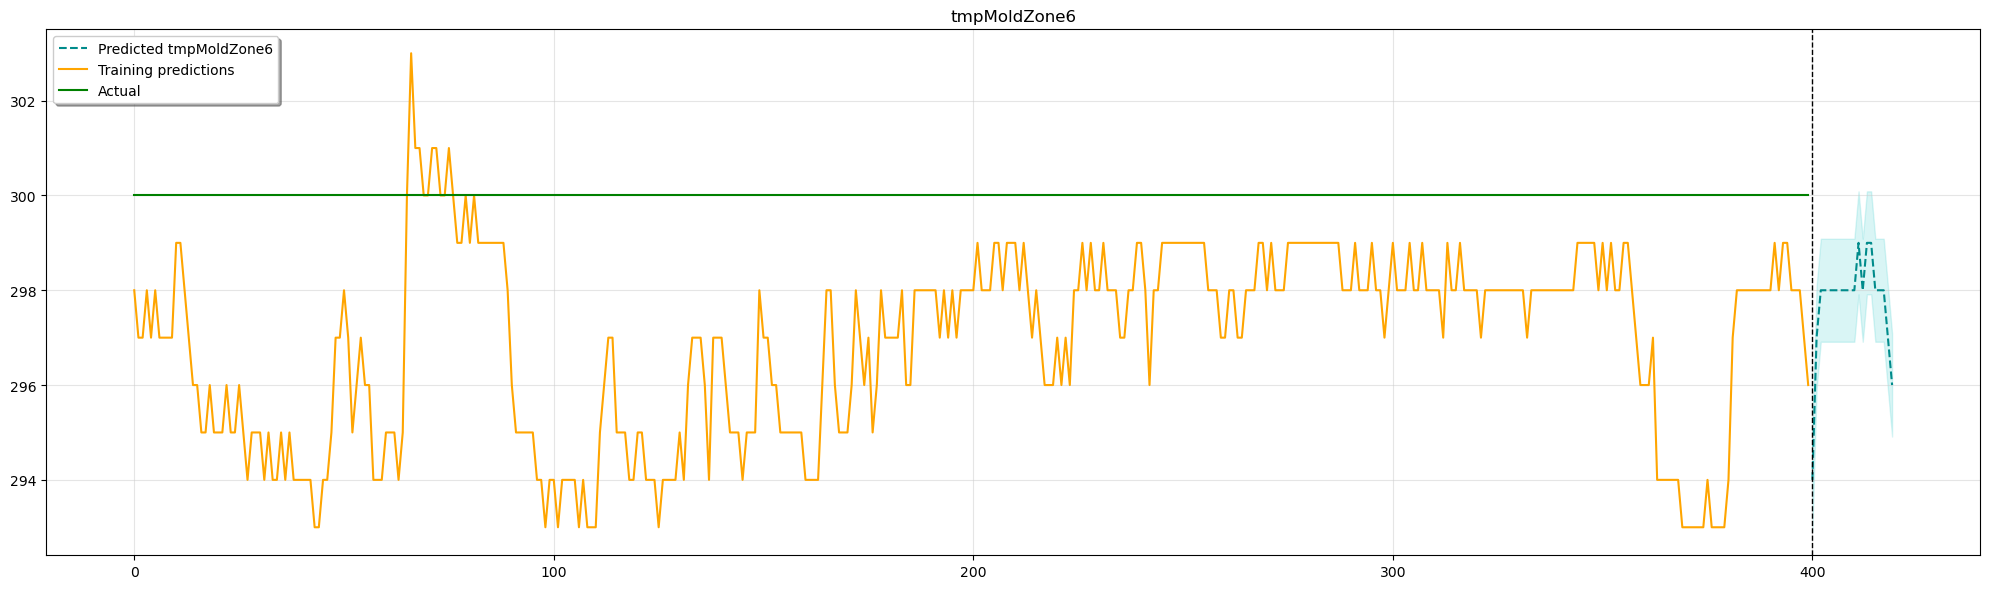

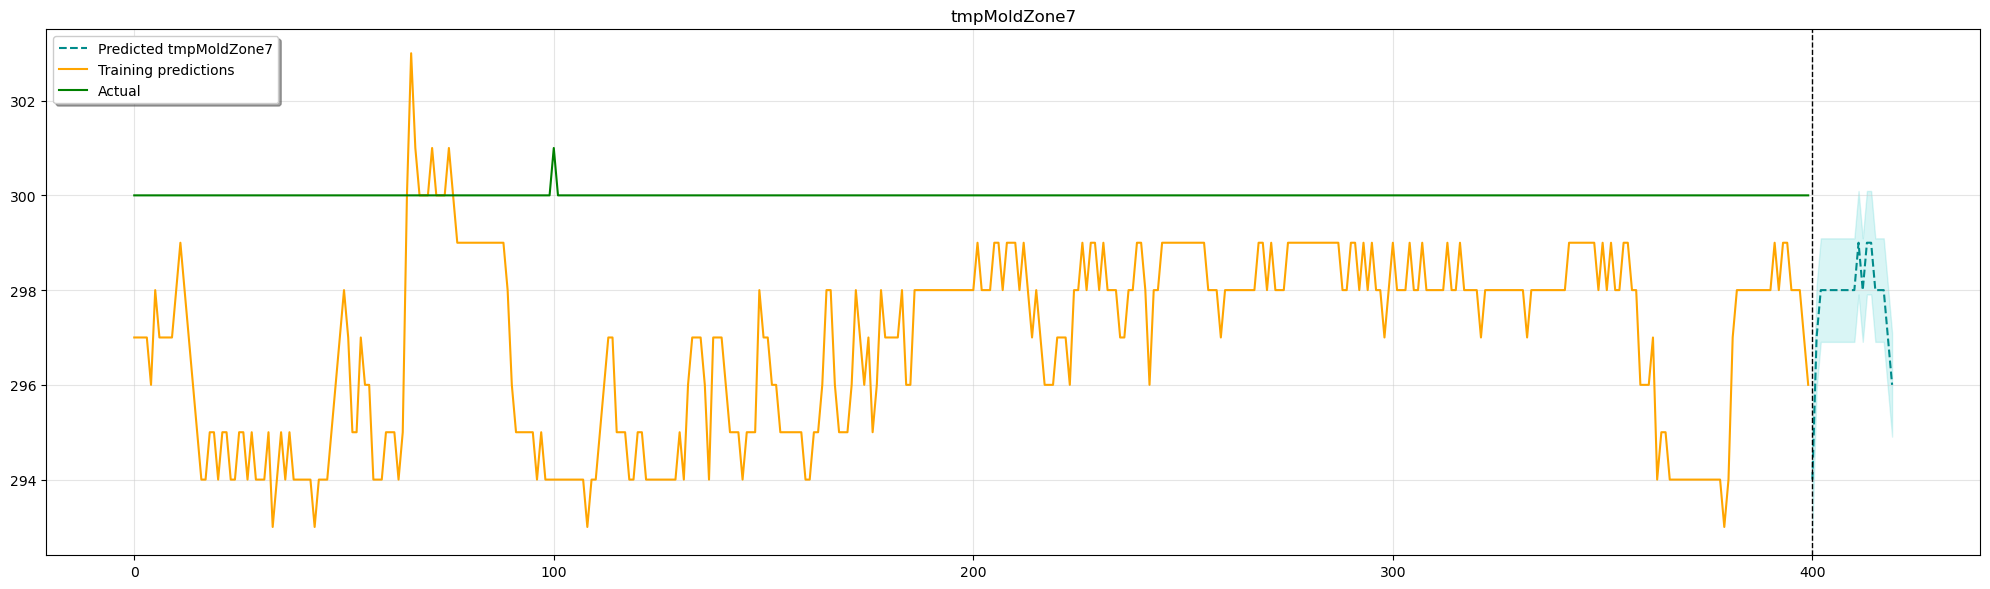

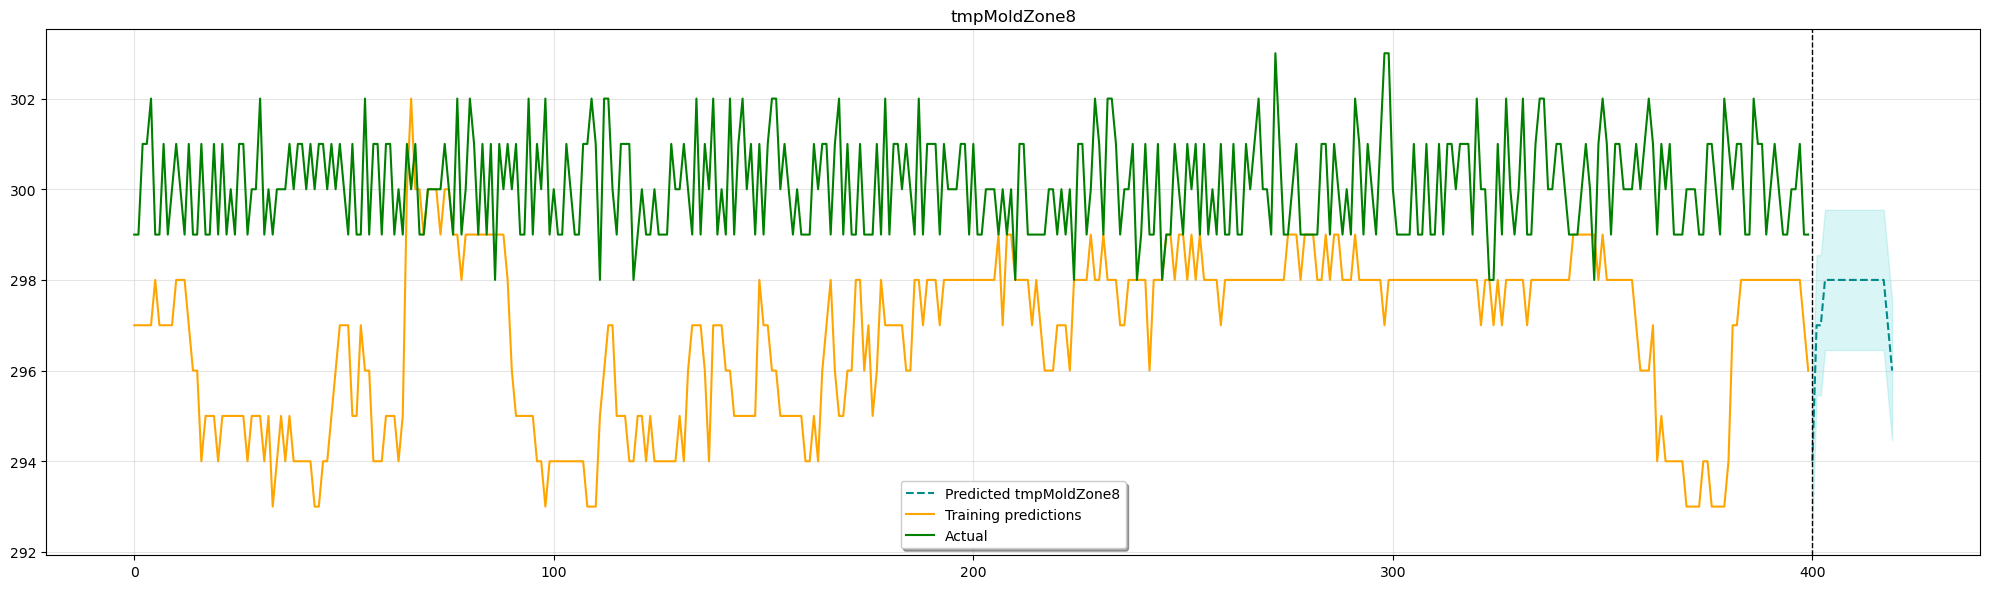

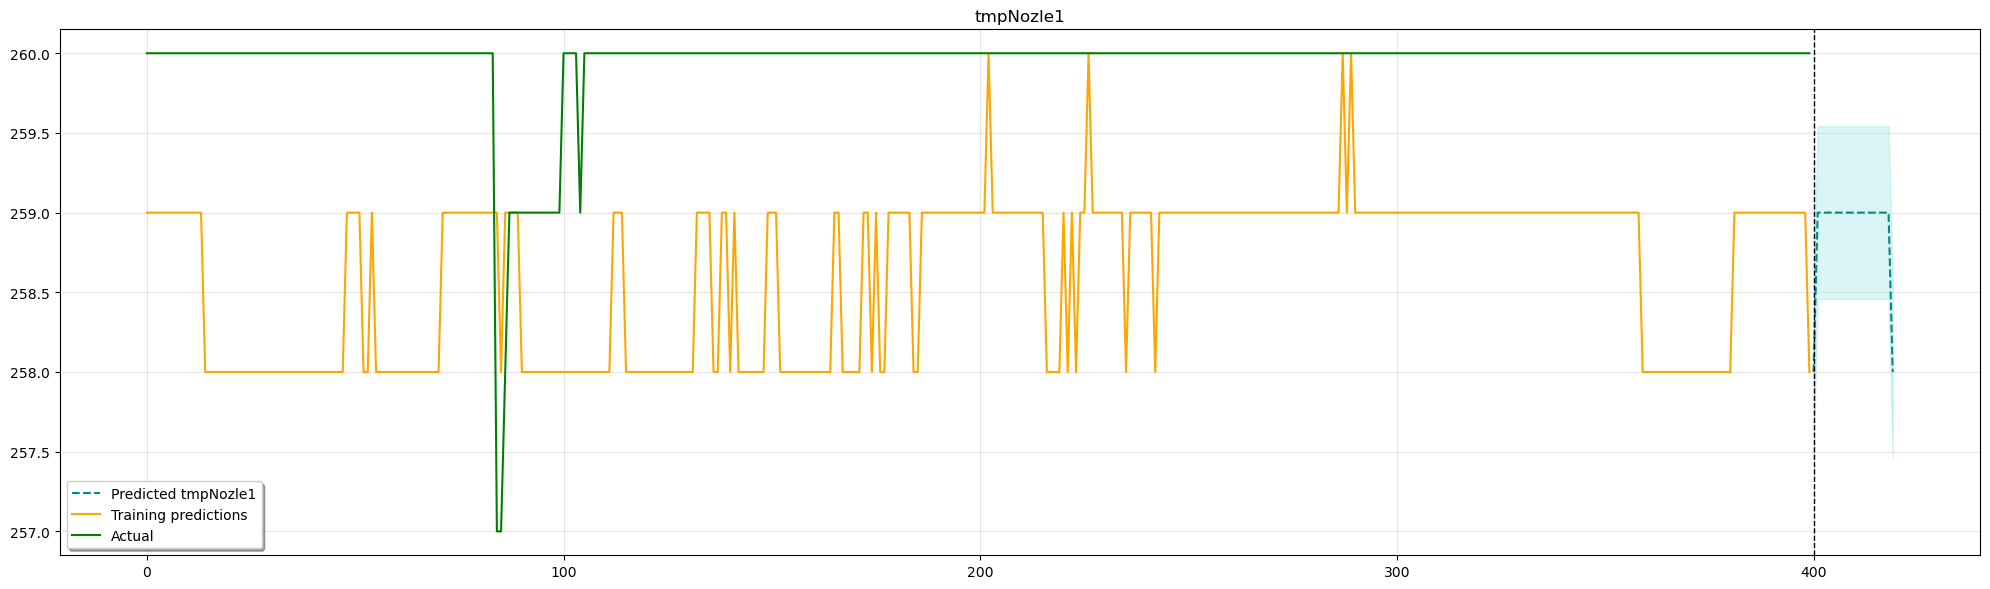

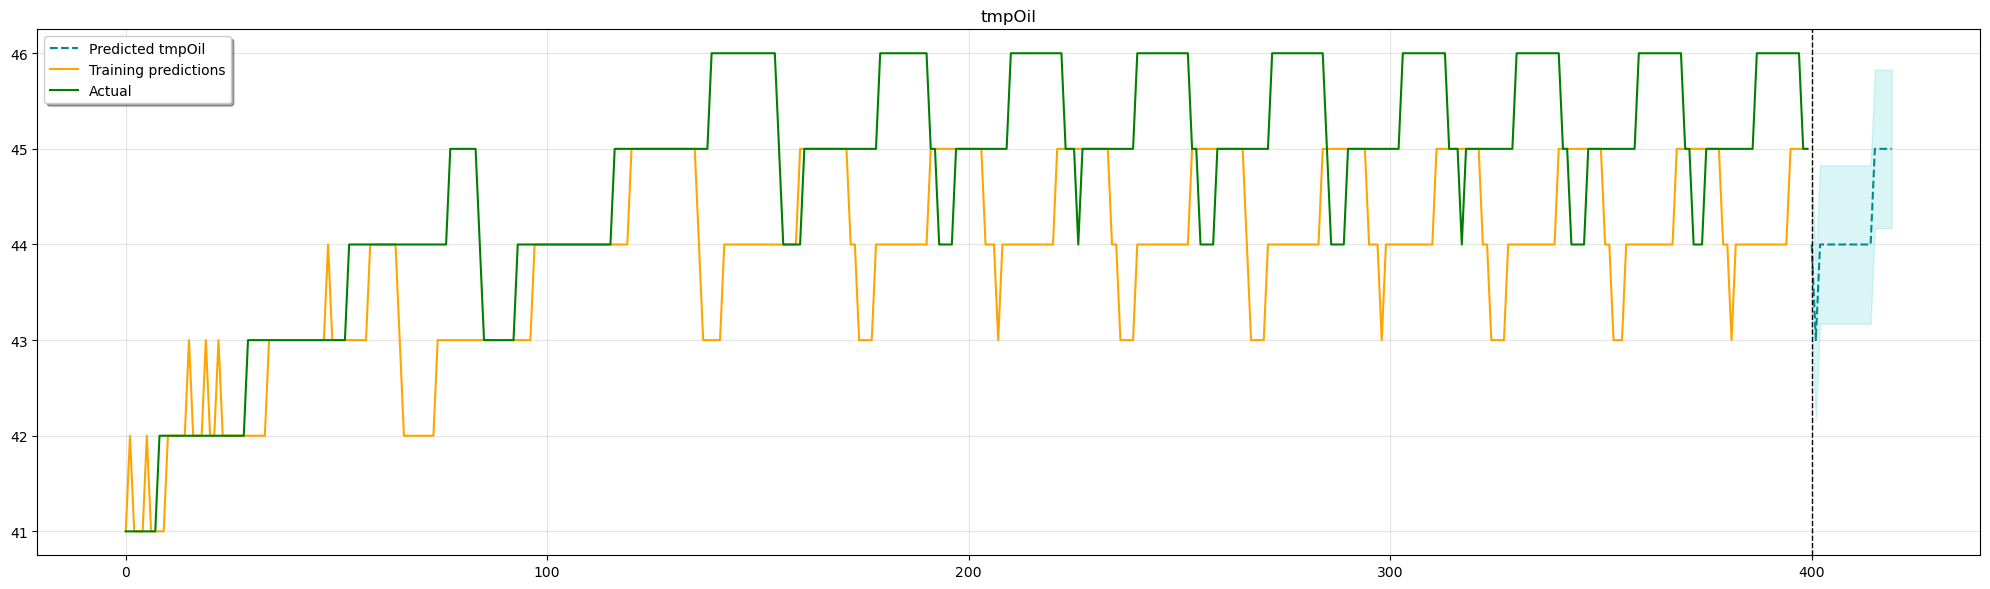

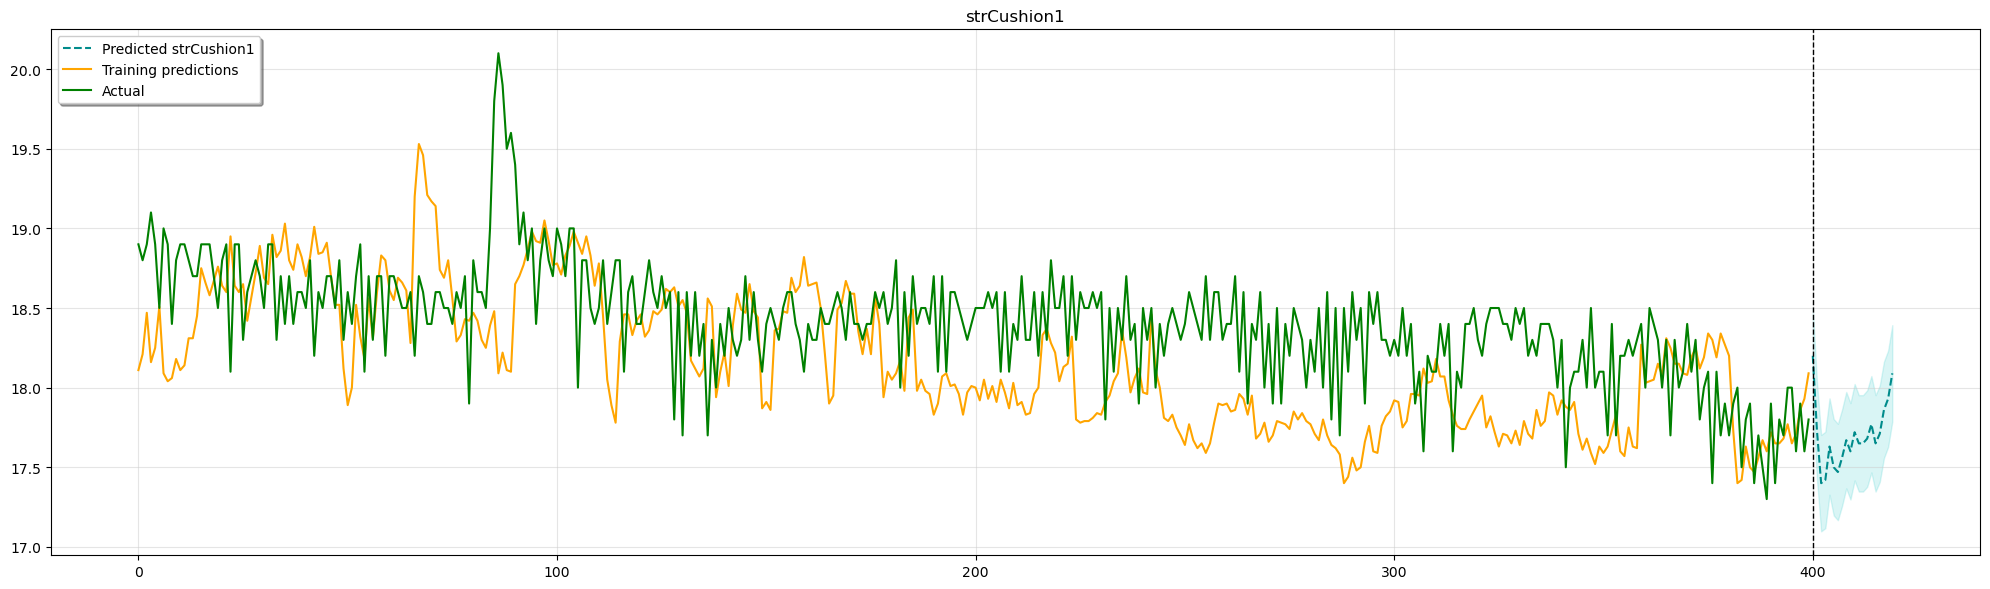

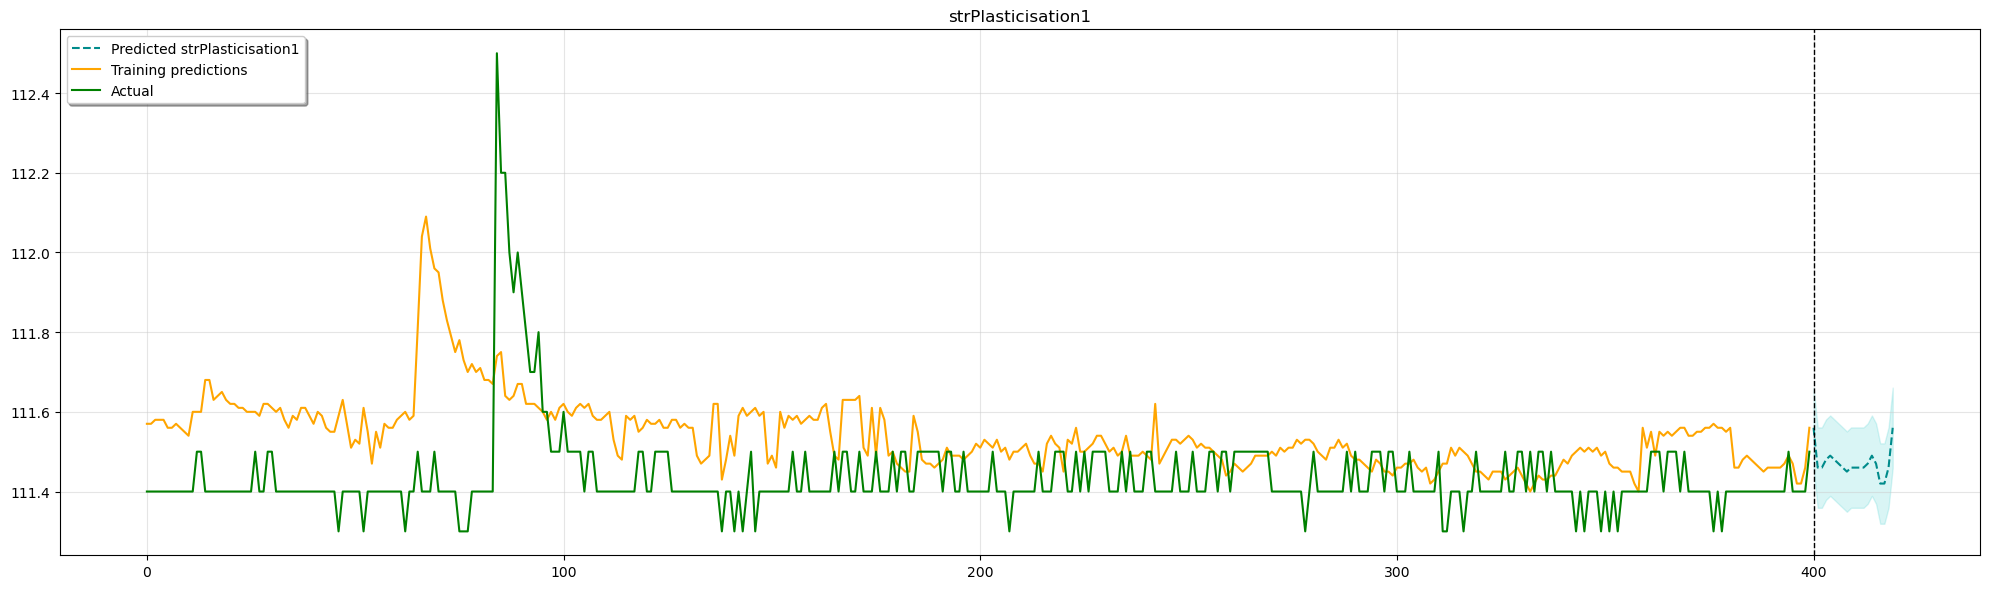

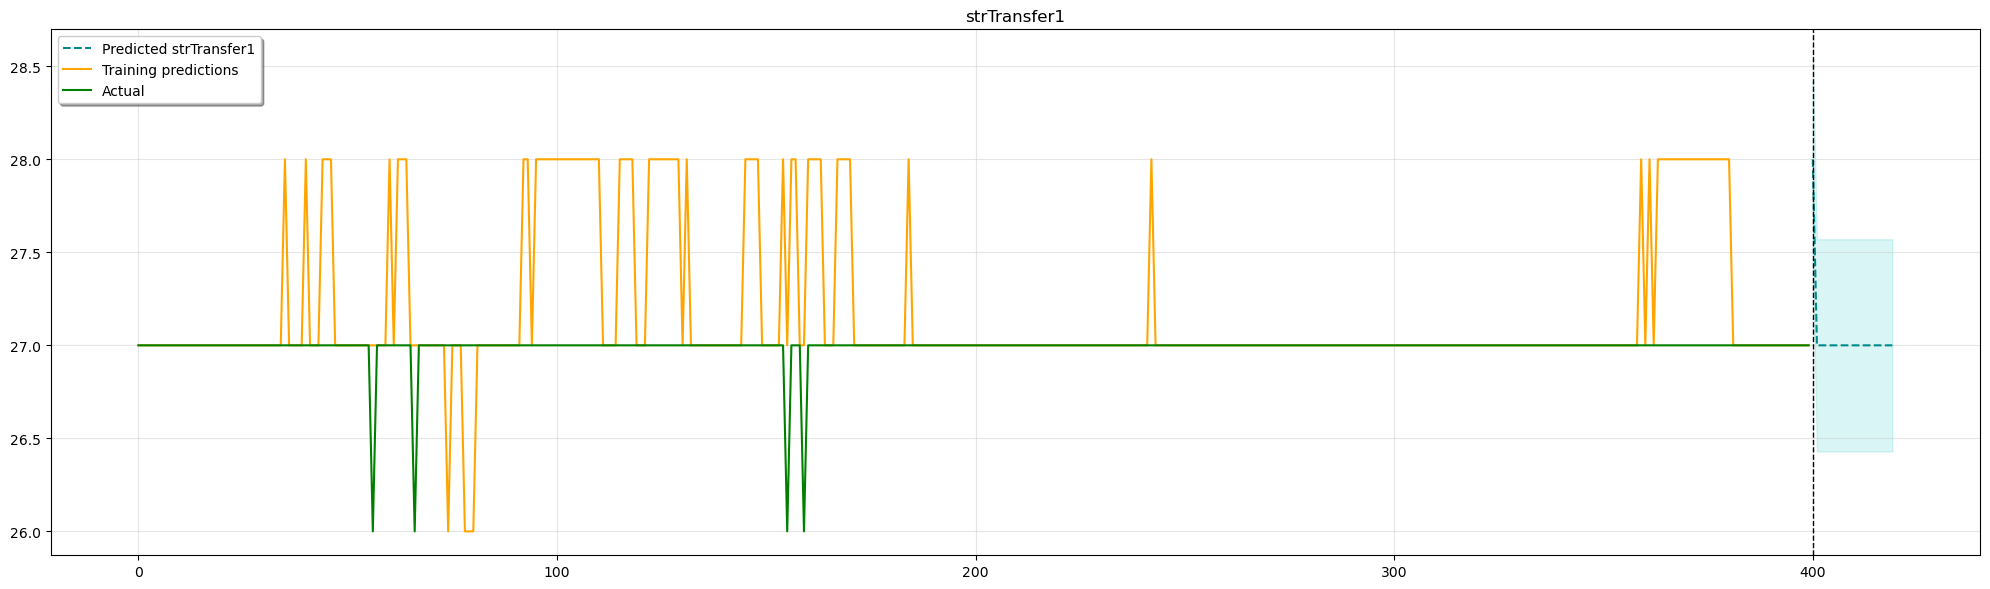

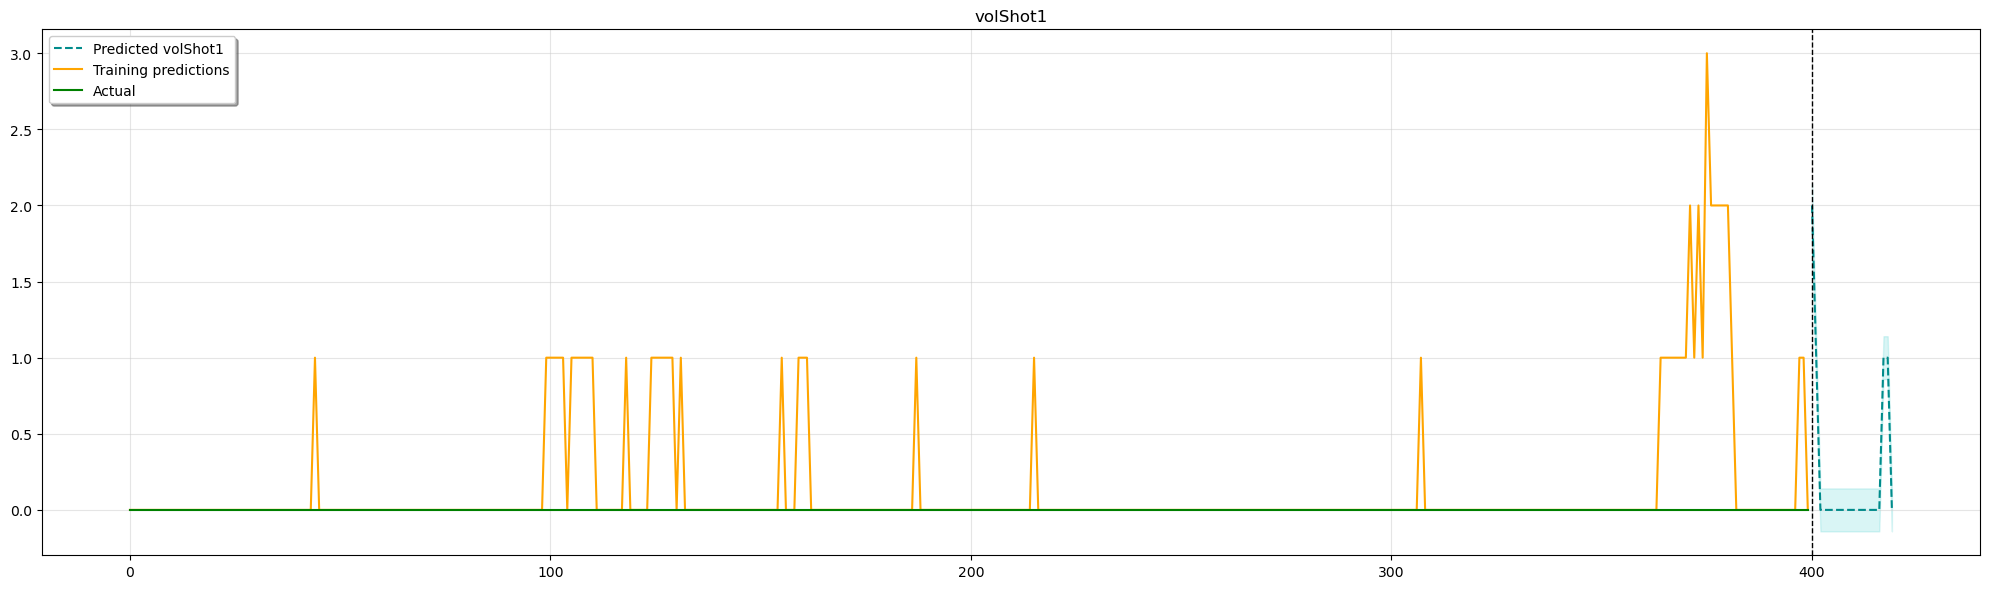

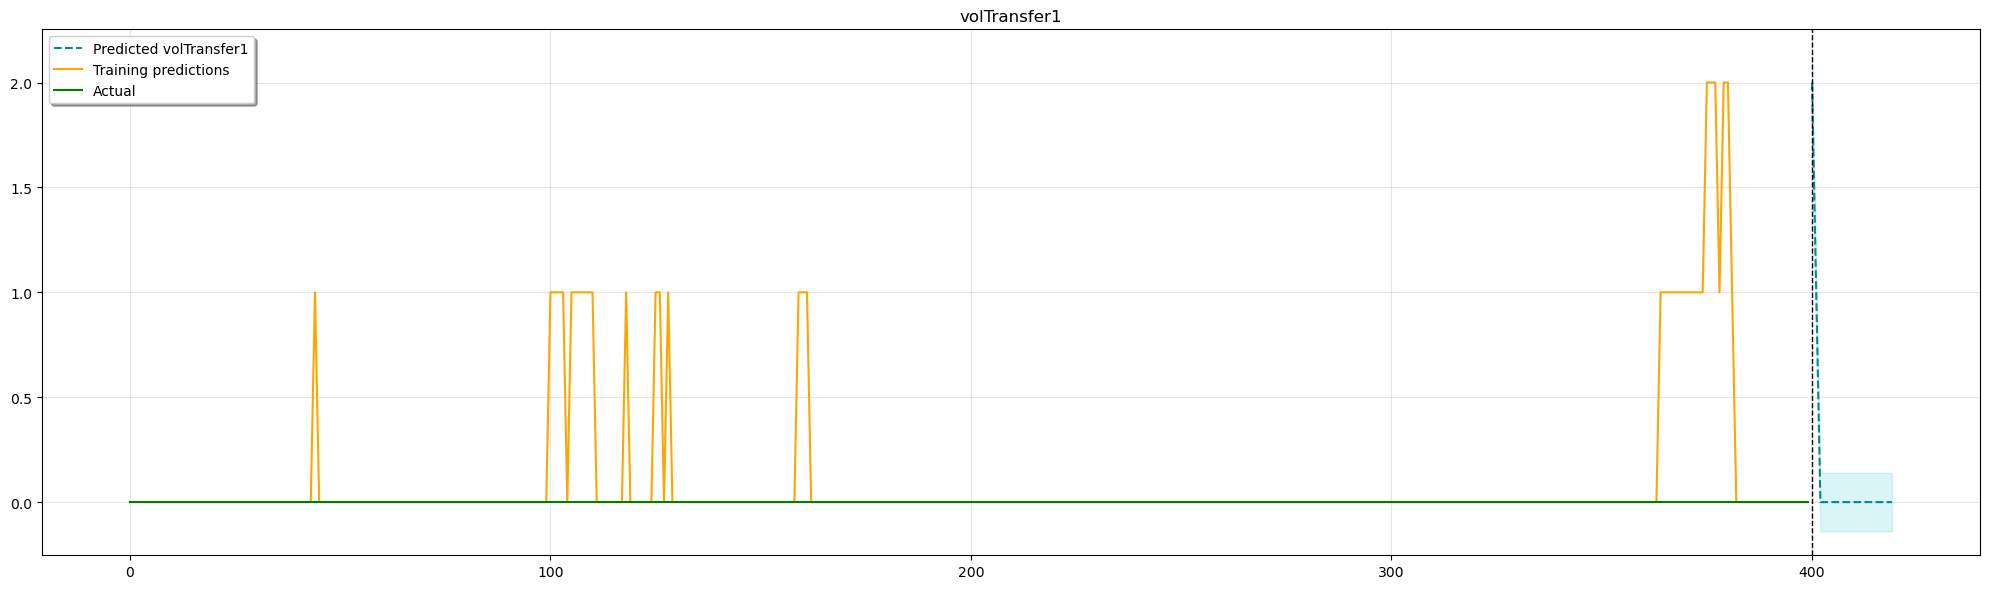

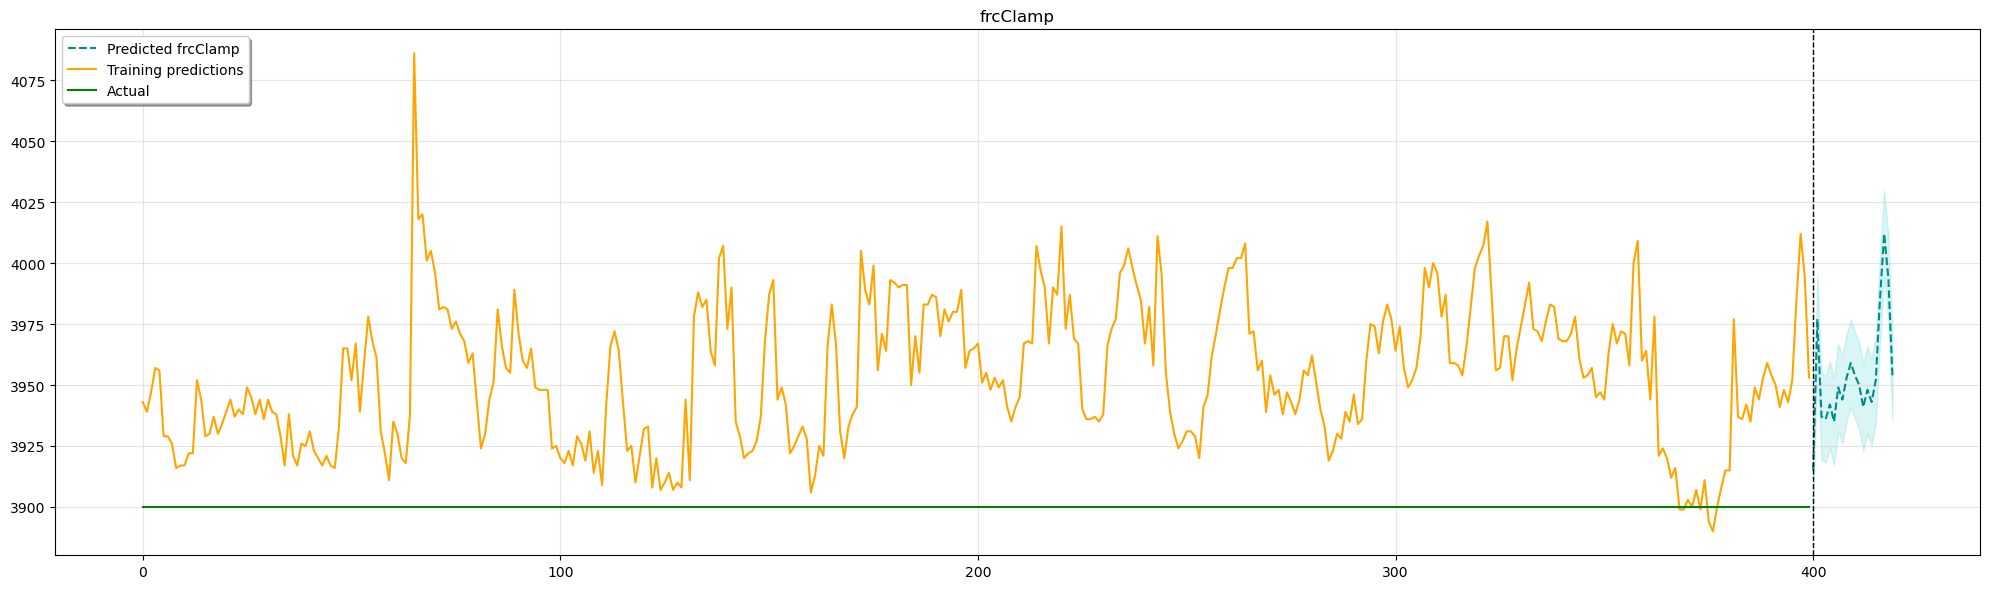

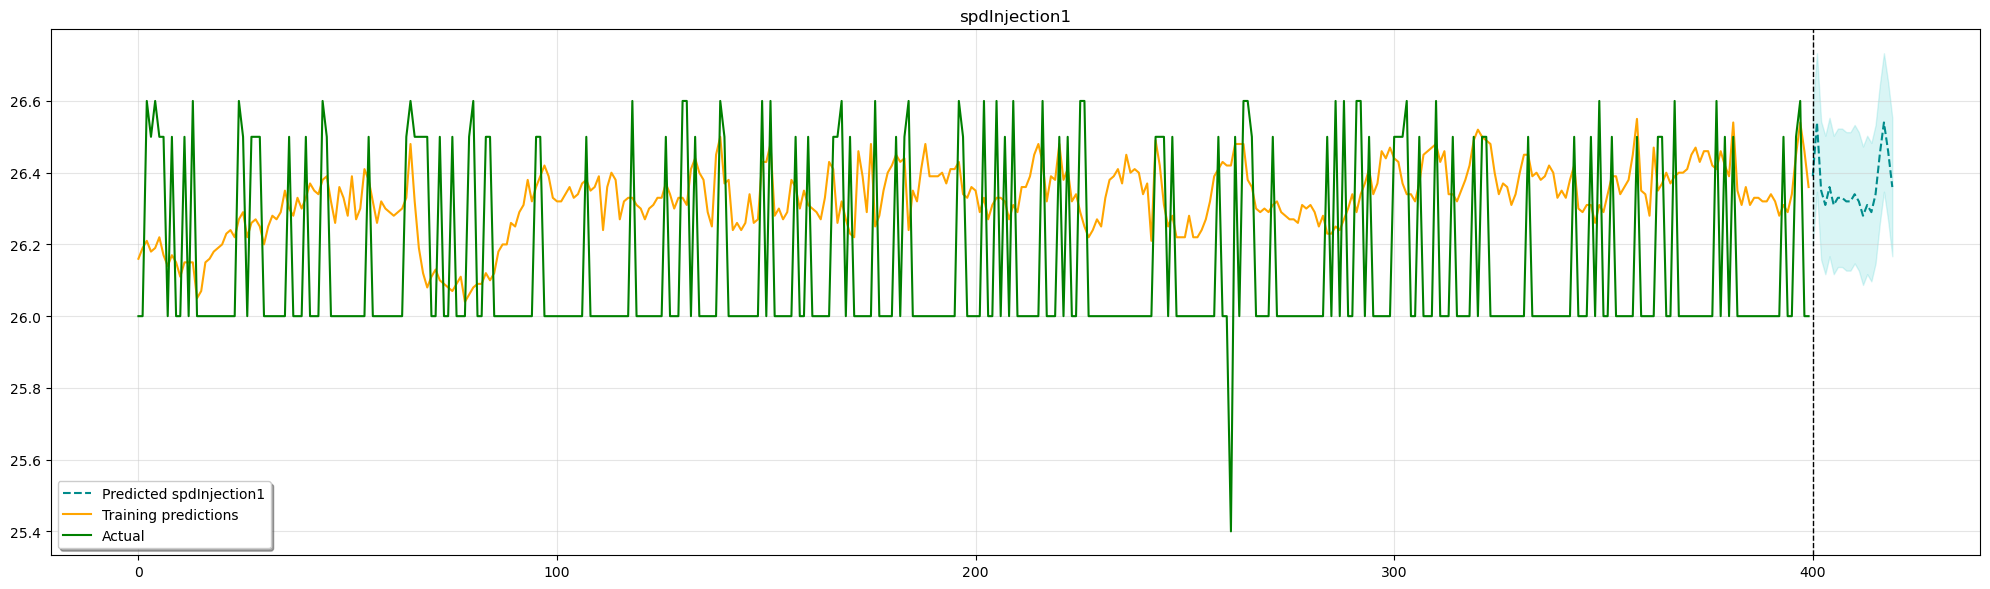

In [16]:
for column in df.columns:
  # Set plot size
  # from pylab import rcParams
  plt.rcParams['figure.figsize'] = 20, 6
  plt.rcParams['figure.dpi'] = 100
  thres = abs(df[column][:-n_steps] - PREDICTION_TRAIN[column]).mean()
  lower = PREDICTIONS_FUTURE[column] - thres
  upper = PREDICTIONS_FUTURE[column] + thres

  x1 = np.arange(start=amount, stop=amount + n_steps)
  x2 = np.arange(len(PREDICTION_TRAIN[:amount]))
  x3 = np.arange(len(dataset[:amount]))

  plt.plot(x1, PREDICTIONS_FUTURE[column], color="darkcyan", linestyle="--", label=f'Predicted {column}')
  plt.fill_between(x1, lower, upper, color='c', alpha=.15)
  
  plt.plot(x2, PREDICTION_TRAIN[column].tail(amount), color='orange', label='Training predictions')
  plt.plot(x3, df[column][:-n_steps].tail(amount), color='green', label='Actual')

  plt.axvline(x = amount, color='black', linewidth=1, linestyle='--')

  plt.grid(which='major', color='#cccccc', alpha=0.5)

  plt.legend(shadow=True)
  plt.title(column)
  plt.show()
  print('\n')